# Creative Nation official data analysis

This notebook contains the core of the data analysis for creative nation.

We will load a variety of official data sources (BRES, IDBR, ABS...), explore them and visualise them. We will generate figures to be used in the report.

**Stages**

* Load data and metadata
* Process data
* Generate visualisations


In [370]:
%matplotlib inline
import pysal
from scipy.stats import linregress
import geopandas as gp
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import mpld3
import matplotlib.patches as mpatches
import matplotlib as mpl
import squarify
from matplotlib import patches


#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

frontier_data = ext_data+'/frontier'

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/final_figures')

#Tables
tab_path = os.path.join(top,'reports/tables')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [3]:
#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['year'] = year
    
    return(lqs)

def descale(vector,vmin,vmax):
    '''
    Descales a vector
    
    '''
    
    descaled = [((x - min(vector)) / (max(vector) - min(vector) )) * (vmax - vmin) + vmin for x in vector]
    
    #descaled = [(val+vmin)*(vmax-vmin) for val in vector]
    
    return(descaled)


def var_changes(factors,size,name=None):
    '''
    This function modifies the levels of employment and/or productivity in a type of creative
    business (based on size) and returns uplifts in GVA (also as rates) and uplifts in GVA per worker (also as rates)
    
    '''
    
    #Increases number of jobs and GVA based on the scale factors
    jobs_uplifted = prod_stats['cr_employment_{size}'.format(size=size)]*factors[0]
    
    gva_p_w_uplifted = prod_stats['cr_gva_pw_{size}'.format(size=size)]*factors[1]
    
    #Increase in GVA equals GVA due to scale up minus old GVA
    gva_uplift = jobs_uplifted*gva_p_w_uplifted  - prod_stats[
        'cr_employment_{size}'.format(size=size)]* prod_stats['cr_gva_pw_{size}'.format(size=size)]
    
    #Final GVA equals increase in GVA plus original GVA
    total_gva_uplifted = gva_uplift+ prod_stats['gva']
    
    #Similar thing with employment
    employment_uplift = jobs_uplifted - prod_stats['cr_employment_{size}'.format(size=size)]
    
    #Final new employments
    total_jobs_uplifted = employment_uplift + prod_stats['employment']
    
    #Create the output DF
    estimate_df = pd.DataFrame({
        'gva_uplift':gva_uplift,
        'employment_uplift':employment_uplift})
    
    #Give it an index
    estimate_df.index= prod_stats.index
    
    return(estimate_df)


def get_share_over_variable(df,var,grouper,drop):
    '''
    
    #This function groups over all the other variables in the DF and returns the share of the variable in the total.
    #Grouper are the variables to group over, drop is a variable to drop
    
    '''
    
    #Drop the variable we don't want (in this case, it is the second year - which we don't want to group by
    #because then we get the shares over a single observation!)
    if drop!=None:
        df = df.drop(drop,axis=1)
    
    #Create variables to group over
    other_vars = [x for x in df.columns if x not in [var,grouper]]
    
    #Produce the share
    out = df.groupby(other_vars)[var].apply(lambda x: x/x.sum())
    
    #Out it comes
    return(out)

def extract_growth_stats(df,name):
    '''
    This function takes a growth estimate df like those above and returns one with
    the variables we want to plot: New GVA, new GVA per worker, their increase rate.
    
    '''
    
    #GVA per worker
    gva_pw = (df['gva_uplift']+prod_stats['gva'])/(df['employment_uplift']+prod_stats['employment'])
    gva_pw_rate = gva_pw/prod_stats['gva_pw']
    
    #GVA
    gva_up = df['gva_uplift']    
    gva_up_rate = (df['gva_uplift']+prod_stats['gva'])/ prod_stats['gva']
    
    #Columns names 
    col_names = [name+'_'+x for x in ['gva_pw','gva_pw_rate','gva_up','gva_up_rate']]
    
    out_df = pd.concat([gva_pw,gva_pw_rate,gva_up,gva_up_rate],axis=1)
    out_df.columns= col_names
    
    return(out_df)

def extract_cumulatives(my_series,variable,my_breaks,sector):
    '''
    This function takes a variable and a list of breaks (rankings)
    It returns a table with the % of activity by group
    It also takes the sector name to label the series (it helps later when we concatenate variables)
    
    '''
    
    #Load my series, create shares and sort to get bigger TTWAs at the top
    ordered = my_series.dropna().sort_values(ascending=False).reset_index(drop=True)/my_series.sum()
    
    
    #Turn this into a dataframe
    ordered_df = ordered.reset_index(drop=False)
    
    #Bin into categories
    ordered_df['bins'] = pd.cut(ordered_df.index,my_breaks,include_lowest=True,right=False)
    
    #Aggregate over categories
    cumulative = ordered_df.groupby('bins')[variable].sum().cumsum()    
    cumulative.name=sector
    return(cumulative)

def cluster_map(df,ax,sector,esp_var,act_var,my_cmap='YlOrRd',threshold=0.75):
    '''
    Creates a choropleth for a sector and variable. Considers a specialisation variable to 
    colour and an activity variable to threshold
    
    '''
    
    #Map
    map_data = df.loc[df.sector==sector,:]
    
    #Select the data to map if there is specialisation and the variable is above a certain threshold
    map_data['processed'] = [x if x>1 and y> map_data[act_var].quantile(threshold) else np.nan 
                             for x,y in zip(map_data[esp_var],map_data[act_var])]
    
    #Then quantise
    map_data['processed_quantised'] = pd.qcut(map_data['processed'],
                                             q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
   
    #Plot map
    map_data.plot(ax=ax,color='lightgrey',
                  #edgecolor='white',linewidth=0.5
                 )
    
    
    m=map_data.dropna(axis=0,subset=['processed']).plot(ax=ax,
                  column='processed_quantised',
                  #color=['coral' if x >1 else 'steelblue' for x in map_data[variable_to_map]],
                  #legend=True,
                                                      cmap=my_cmap
                 )
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    ax.set_title(sector,y=1.01,size=12)
    return(m)

#Function to extract neighbour stats
def get_neighbour_stats(df,sector,var):
    '''
    This function loops over each TTWA and estimates the mean scores of its neighbours in a variable (for a sector)
    It returns a dataframe with the means and a matrix combining their scores
    
    '''
    
    #Is it employment or bc?
    
    if var=='emp':
        var_1 = 'emp_lq_change'
        var_2 = 'emp_growth'
    else:
        var_1 = 'bc_lq_change'
        var_2 = 'bc_growth'
    
    
    #First step: subset by sector
    df_sector = df.loc[df.sector==sector,:]
    
    #Create a container
    cont = []
    mat = []
    #Second step: 
    #For each TTWA, subset by the neighbors and calculate averages.
    for x in df_sector['ttwa_name']:
        
        #Area's own score
        own_score = float(df_sector.loc[df_sector.ttwa_name==x,var_1])
        
        #Extract neighbours
        try:
            neighs = neighbors_looked_up[x]
    
            #Subset variable to get neighbours
            neighbours = df_sector.loc[[x in neighs for x in df_sector['ttwa_name']],['ttwa_name',var_1]]
            
            #Calculate mean
            value = neighbours[var_1].dropna().mean()
            
            #Create new DF with all the neighbour info
            neighbours_2 = neighbours.set_index('ttwa_name')
            
            #Name the neighbours and transpose for concatenating on rows
            neighbours_2.columns=[x]
            neighbours_2 = neighbours_2.T
            
            #Create series
            out = pd.Series({'ttwa_name':x,'neighs':", ".join(neighs),'{n}_neighbor'.format(n=var):value,
                           '{n}_own'.format(n=var):own_score})
            
            mat.append(neighbours_2)

            
        except:
            out = pd.Series({'ttwa_name':x,'neighs':np.nan,'{n}_neighbor'.format(n=var):np.nan,
                           '{n}_own'.format(n=var):own_score})
        
        
        cont.append(out)


    
    #Out simple
    out_df = pd.DataFrame(cont).reset_index(drop=True)    
    
    #Add quantised data
    df_sector['{var}_growth_q'.format(var=var)] = pd.qcut(
        df_sector[var_2],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop') 
    
    
    #Out matrix
    out_mat = pd.concat(mat)
    
    return([pd.concat([out_df.set_index('ttwa_name'),
                       df_sector.set_index('ttwa_name')],axis=1)])
        

    
def map_sector(sector,ax,df,neighbor_lookup,my_cmap='RdBu_r'):
    '''
    This function takes a sector and plots it, together with the scatter showing area / neighbour performance
    
    '''
    
    #Subset
    map_data = ttwa_merged.loc[ttwa_merged.sector==sector,:]
    
    #Quantise the employment change df
    map_data['employment_change_q']= pd.qcut(map_data['employment_change'],
                                           q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    
    #Plot map
    map_data.plot(column='employment_change_q',
              ax=ax,cmap=my_cmap)
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    #Add title (inserting breaks if needed)
    
    #split=sector.split(" ")
    
    #If the number of words is above 3 it in
    #split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    #if '\n' not in split_rejoined:
    #    split_rejoined+=' \n'
    
    ax.set_title(sector,y=1.01,size=12)

    
    # Manually set the position and relative size of the inset axes within ax1
    ax2 = inset_axes(ax,
                     width='30%',  # width = 10% of parent_bbox width
                     height=1,  # height : 50%
                     #loc=1,bbox_to_anchor=(0,0,1,1)
                     loc=1
                    )

    
    #Other data
    scatter_data = neighbor_lookup[sector]
    
    #Remove infinites for the linear regression analysis
    lr_data = scatter_data[['emp_neighbor','emp_own']].replace([np.inf, -np.inf], np.nan)
    lr_data.dropna(inplace=True)
    
    #Regress
    linres = linregress(lr_data.iloc[:,0],lr_data.iloc[:,1])
    
    #print(linres)
    
    #Plot
    ax2.plot(
        #Exes
        [lr_data['emp_neighbor'].min(),
        lr_data['emp_neighbor'].max()],        
        
        #Ys (including intercept and regression coefficient)
        [linres[1],
            #lr_data['emp_own'].min()+linres[1],
         lr_data['emp_own'].max()*linres[0]+linres[1]],
        
        #Styles
        color='black',linestyle='--',linewidth=1)
    
    #Add x & y vlines
    ax2.vlines(x=1,
                   ymin=lr_data['emp_own'].min(),
                   ymax=lr_data['emp_own'].max(),color='grey',linestyle=':',linewidth=1)
    
    ax2.hlines(y=1,xmin=lr_data['emp_neighbor'].min(),
                   xmax=lr_data['emp_neighbor'].max(),color='grey',linestyle=':',linewidth=1)
    
    ax2.set_ylim([0,lr_data.emp_own.max()])
    
    
    #Plot region data
    for region in set(scatter_data['region']):
        #print(reg)
        sub_data = scatter_data.loc[[r==region for r in scatter_data.region],:]
        
        
        ax2.scatter(sub_data['emp_neighbor'],sub_data['emp_own'],
                        s=3*sub_data['emp_growth_q'],
                        color=color_lookup[region],
                        edgecolor=['red' if val>0 else 'blue' for val in sub_data['emp_growth']],
                        linewidth=0.5,alpha=0.7
                       )
        
    ax2.tick_params('both',size=8)
    
    ax2.set_ylabel('Growth in area',size=8)
    ax2.set_xlabel('Growth in \n neighbour (mean)',size=8)
    
    return(ax)


def process_gdyn_data(df,name):
    '''
    Processes a growth dynamics dataframe
    '''
    gdf = df.loc[df.cohort=='2013-2016',my_vars].reset_index(drop=True).loc[:10].set_index('Unnamed: 1')
    
    gdf['share_all_firms'],gdf['share_all_employment'] = [gdf[x]/gdf[x].sum() for x in 
                                                          ['Number of firms','Change in employment']]
    
    gdf['jobs_per_firm'] = gdf['Change in employment']/gdf['Number of firms']
    
    
    gdf['sector'] = name
    
    return(gdf)
    
def process_survival(sheetname):
    '''
    Reads and processes a 'survival' file
    
    
    '''
    
    surv = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC.xlsx',sheetname=sheetname)
    surv['industry']= ['creative' if x!='Other or unknown' else 'non_creative' for x in surv['industry']]


    surv_totals = surv.groupby('industry').sum()

    surv_out = surv_totals.loc[:,['rate' not in x for x in surv_totals.columns]].apply(lambda x: x/x[0],axis=1)
    
    return(surv_out) 


#Employment diversity

def herfindahl(series):
    '''
    Extract the herfindahl index for a series (sum of squared market-shares)
    
    '''

    hi = sum([(x/np.sum(series))**2 for x in series])
    return(hi)

def add_positives(series):
    '''
    Returns the sum of the positives in a series
    
    '''
    out = np.sum(series>1)
    return(out)

def normalise(series):
    '''
    Normalises the series
    
    '''
    
    norm = [(x - series.mean())/series.std() for x in series]
    return(norm)


def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)    



### Metadata

In [4]:
#A couple of missing TTWAs in the data below

missing_ttwas = pd.DataFrame({'region': {0: 'West Midlands', 1: 'Scotland', 2: 'South East', 3: 'Scotland'},
 'ttwa_code': {0: 'E30000277', 1: 'S22000013', 2: 'E30000278', 3: 'S22000013'},
 'ttwa_name': {0: 'Telford',1: 'Western Isles',2: 'Thanet',3: 'Eilean Siar'}}).reset_index(drop=True)

In [279]:
#TTWA names, region lookups, information about whether a TTWA is a cluster or not

#Codes and names
ttwa_name_df = pd.concat([pd.read_csv(ext_data+'/ttwa_name_df.csv'),
                          missing_ttwas[['ttwa_code','ttwa_name']]]).reset_index(drop=True)


#TTWA Code - name lookup
ttwa_name_lookup = {x:y for x,y in zip(ttwa_name_df.ttwa_code, ttwa_name_df.ttwa_name)}

#Regions and info about whether they are a cluster
ttwa_region_df = pd.read_excel(ext_data+'/geography_of_creativity_data.xlsx',sheet_name=0)

ttwa_region_lookup = {x:y for x,y in zip(ttwa_region_df.TTWA,ttwa_region_df.region)}

#Add regions for the missing ones
ttwa_region_lookup['Thanet'] = 'South England'
ttwa_region_lookup['Eilean Siar']= 'Scotland'
ttwa_region_lookup['Western Isles'] = 'Scotland'
ttwa_region_lookup['Telford'] = 'West Midlands'


#Turn into a list
ttwa_is_cluster = list(ttwa_region_df.loc[ttwa_region_df.creative_cluster=='yes','TTWA'])

#Add Birmingham
ttwa_is_cluster.append('Birmingham')

#Rename
my_ttwas = ttwa_is_cluster


In [286]:
#Import python for spatial analysis library

#Create lookup of ttwas
ttwa_names_to_codes_lookup = {v:k for k,v in ttwa_name_lookup.items()}

#Add some missing codes
for name,code in zip(['Telford','Western Isles','Thanet','Eilean Siar'],
                     ['E30000277', 'S22000013', 'E30000278', 'S22000013']):
    ttwa_names_to_codes_lookup[name]=code


ttwas_coded = pd.DataFrame({'ttwa_code':[x for x in ttwa_names_to_codes_lookup.values()],
                            'ttwa_name':[x for x in ttwa_names_to_codes_lookup.keys()]})


In [7]:
#Geographical stuff
#Get Shapefile here:
#https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip

#Load shapefile
shapefile_loc = ext_data+'/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3'

ttwa_shp = pysal.open(shapefile_loc+'/TTWA_2011_UK_BGC_V3.shp')

#Read shapefile weights and attributes
#And attributes
w = pysal.rook_from_shapefile(shapefile_loc+"/TTWA_2011_UK_BGC_V3.shp")
attr = pysal.open(shapefile_loc+"/TTWA_2011_UK_BGC_V3.dbf")



/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 9, 166, 167, 168, 169
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


### IDBR ((Interdepartmental Business Register) data

The interdepartmental business register is a register of UK business with information about number of businesses, employment and turnover by TTWA. We report company descriptives based on an analysis of IDBR microdata, size distribution information using data from NOMIS (a portal for official labour market statistics) and some data processed by Frontier Ecomnomics at the Virtual Microdata laboratory.

We load these things in turn

In [8]:
#Load idbr frontier data
idbr_frontier = pd.read_csv(frontier_data+'/8_1_2018_idbr_frontier.csv')

idbr_frontier.head()

,business_count,employment,industry,ttwa_code,ttwa_name,year
0,65.0,190.0,Advertising and marketing,S22000047,Aberdeen,2015_2016
1,1247.5,3635.0,All creative industries,S22000047,Aberdeen,2015_2016
2,182.5,495.0,Architecture,S22000047,Aberdeen,2015_2016
3,110.0,205.0,"Design: product, graphic and fashion design",S22000047,Aberdeen,2015_2016
4,82.5,205.0,"Film, TV, video, radio and photography",S22000047,Aberdeen,2015_2016


In [9]:
#Create dataframe with idbr LQs
#Subsectoral (ie we remove the all creative industries when estimating the LQs)

#This calculates yearly employment and business count LQs by creative subsector with the function we defined above.
#NB we remove all creative industries to avoid double counting

#We are using a list comprehension to choose what variable to process
empl_lqs_subsectoral, bc_lqs_subsectoral = [pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & (idbr_frontier['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values=variable)) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False) for variable in 
                                           ['employment','business_count']]

#Here we calculate yearly employment LQs in creative industries and outside. We remove
#all creative subsectors to avoid double counting

empl_lqs_sectoral, bc_lqs_sectoral = [pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_frontier['industry']]),:],
                                index=['year','ttwa_name'],columns='industry',values=variable)) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1) 
                                      for variable in 
                                           ['employment','business_count']]


#This contains employment and BC totals
empl_totals, bc_totals = [pd.pivot_table(idbr_frontier,index=['ttwa_name','ttwa_code','year'],columns='industry',
                            values=variable).reset_index(drop=False) for variable in ['employment','business_count']]


#A long version of the business count totals that we also use later
bc_totals_long = idbr_frontier.drop('employment',axis=1)


In [10]:
### IDBR DATA FROM NOMIS

In [11]:
#Load IDBR data
idbr_totals = pd.read_csv(int_data+'/5_11_2017_idbr_totals.csv')
idbr_sizebands = pd.read_csv(int_data+'/5_11_2017_idbr_sizeband.csv')

#Concatenate
idbr_all = pd.concat([idbr_totals,idbr_sizebands])

#Produce LQs
idbr_all_wide = pd.pivot_table(idbr_all.loc[idbr_all.sizeband=='Total'],
                               index=['year','ttwa_name'],columns='sector',values='value').reset_index(drop=False)

### ABS (Annual Business Survey)

The Annual Business Survey is a database with information about the productivity of UK businesses. We will use these data in our productivity analysis


In [548]:
#Load GVA data from Frontier
gva = pd.read_excel(frontier_data+'/spd-GVA stats-15-11-2017v2.xlsx',sheetname=2)

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [549]:
gva.head()

,Region,Employment size band,Total approximate basic GVA,Employment,Number of enterprises,GVA per employee,Industry,Sample size,Period
0,North East,0-9,859290,22490,11140,38,Creative,98,2013-15
1,North East,0-9,15713890,454660,175020,35,Other or unknown,2122,2013-15
2,North East,10+,1730480,29730,745,58,Creative,54,2013-15
3,North East,10+,73236070,1510710,28750,48,Other or unknown,2518,2013-15
4,North West,0-9,3738600,76610,45020,49,Creative,398,2013-15


In [551]:
#Load the Northern Ireland data
gva_ni = pd.read_excel(frontier_data+'/Creative Industries - NIABI RU 2013-15 (1).xlsx',sheetname=5)

gva_ni_2013_2015 = gva_ni.groupby(
    ['Employment size band','Industry'])[['Total approximate basic GVA','Employment']].mean().reset_index(drop=False)

gva_ni_2013_2015['Total approximate basic GVA'] = gva_ni_2013_2015['Total approximate basic GVA']*1000
gva_ni_2013_2015['Region'] = 'Northern Ireland'
gva_ni_2013_2015['Period'] = '2013-2015'
gva_ni_2013_2015['Employment size band'] = [
    '0-9' if '9' in x else '10+' for x in gva_ni_2013_2015['Employment size band']]
gva_ni_2013_2015['Industry'] = [
    'Creative' if 'creative' in x else 'Other or unknown' for x in gva_ni_2013_2015['Industry']]

gva_ni_2013_2015['GVA per employee'] = gva_ni_2013_2015['Total approximate basic GVA']/gva_ni_2013_2015['Employment']

#Concatenate
gva= pd.concat([gva,gva_ni_2013_2015])

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


### Growth dynamics (IDBR)

The growth dynamics data we use in our analysis is based on an analysis of IDBR micro-data by Frontier Economics


In [14]:
#Growth dynamics data by TTWA with information about types of businesses by growth category, 
# and the employment they generate (or destroy)
gdyn_ttwa = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheet_name=7)

#Survival data
surv_ttwa = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC (1).xlsx',sheet_name=3)

#And UK levels
gdyn_creat = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheet_name=2)
gdyn_non_creat = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheet_name=3)
surv_uk = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC (1).xlsx',sheet_name=1)

In [15]:
gdyn_ttwa.head()

,bandemployment,cohort,ttwa,employment_start,employment_end,turnover_start,turnover_end,entref,d_employment,d_turnover,mnentref,industry
0,birth,200709-201012,E30000004,0,14940,0,1150540,4475,14940,1150540,15,Other
1,bl10dec,200709-201012,E30000004,7070,4240,537280,407440,1660,-2830,-129840,15,Other
2,bl10inc,200709-201012,E30000004,7060,13790,842620,1263350,2440,6730,420730,15,Other
3,bl10sm,200709-201012,E30000004,10370,10370,917860,902920,4965,0,-14930,15,Other
4,bv10dec,200709-201012,E30000004,76580,57560,10909920,8624380,935,-19020,-2285540,15,Other


### Some preliminary statistics
How much of the employment / business counts is accounted by selected creative clusters?

In [16]:
#Employment
empl_totals.loc[(empl_totals.year=='2015_2016') & ([x in my_ttwas for x in empl_totals.ttwa_name]),
                'All creative industries'].sum()/empl_totals.loc[empl_totals.year=='2015_2016',
                'All creative industries'].sum()

0.8259729505934309

In [17]:
#Business count
bc_totals.loc[(bc_totals.year=='2015_2016') & ([x in my_ttwas for x in bc_totals.ttwa_name]),
                'All creative industries'].sum()/bc_totals.loc[bc_totals.year=='2015_2016',
                'All creative industries'].sum()

0.75679000327442325

## 2. Analysis and visualisation

### FACT 1: Growth in the creative industries

We begin by analysing growth in the creative industries compared to other sectors, and producing charts that analyse this growth for all TTWAs and also by region

In [18]:
#Create DF with changes in employment and business counts

#As before, we use list comprehensions to keep the code compact
#This simply rearranges the previous dataframes to calculate period on period changes

empl_changes, bc_changes = [pd.pivot_table(pd.melt(
    df,id_vars=['ttwa_name','ttwa_code','year']).reset_index(drop=False),
                                           index=['ttwa_name','industry'],
                                           columns='year',values='value').reset_index(drop=False) for df in
                            [empl_totals,bc_totals]]

#And create the years
empl_changes['employment_change'], bc_changes['business_change'] = [df['2015_2016']/df['2011_2014'] for df in 
                                                                   [empl_changes, bc_changes]]


#Rename columns in both dataframes
empl_changes.rename(columns={'2015_2016':'emp_2015_2016','2011_2014':'emp_2011_2014',
                             'industry':'sector'},inplace=True)

bc_changes.rename(columns={'2015_2016':'bc_2015_2016','2011_2014':'bc_2011_2014','industry':'sector'},inplace=True)

#Combine empl and bc into a  single dataframe
all_changes = pd.concat([empl_changes.set_index(['ttwa_name','sector']),
                         bc_changes.set_index(['ttwa_name','sector'])],axis=1).reset_index(drop=False)

#Add absolute changes
all_changes['emp_abs_change'] = all_changes['emp_2015_2016'] - all_changes['emp_2011_2014'] 
all_changes['bc_abs_change'] = all_changes['bc_2015_2016'] - all_changes['bc_2011_2014'] 

#Add regions using the TTWA region lookup
all_changes['region'] = [ttwa_region_lookup[x] for x in all_changes['ttwa_name']]


#Need to replace the infinites (in some cases we are dividing by 0)

#Replace infinites with nas and drop nas (otherwise we can't visualise the data)
all_changes.replace([np.inf,-np.inf],np.nan,inplace=True)
all_changes_no_nas = all_changes.dropna()

#all_changes_in_clusters = all_changes.loc[[x in ttwa_is_cluster for x in all_changes.ttwa_name],:]

#all_changes_no_nas['ttwa_code'] =[ttwa_names_to_codes_lookup[x] if x in ttwa_names_to_codes_lookup.keys() else np.nan
#                                  for x in all_changes_no_nas['ttwa_name']]

#all_changes_no_nas.dropna(axis=0,subset=['ttwa_code'],inplace=True)


#This is what it looks like
all_changes.head()

year,ttwa_name,sector,emp_2011_2014,emp_2015_2016,employment_change,bc_2011_2014,bc_2015_2016,business_change,emp_abs_change,bc_abs_change,region
0,Aberdeen,Advertising and marketing,187.00,190.0,1.016043,58.0,65.0,1.120690,3.00,7.0,Scotland
1,Aberdeen,All creative industries,3652.25,3635.0,0.995277,1155.0,1247.5,1.080087,-17.25,92.5,Scotland
2,Aberdeen,Architecture,596.25,495.0,0.830189,191.0,182.5,0.955497,-101.25,-8.5,Scotland
3,Aberdeen,"Design: product, graphic and fashion design",210.75,205.0,0.972716,103.0,110.0,1.067961,-5.75,7.0,Scotland
4,Aberdeen,"Film, TV, video, radio and photography",242.50,205.0,0.845361,84.0,82.5,0.982143,-37.50,-1.5,Scotland


In [19]:
#We want to visualise changes in the creative industries

#Create an employment df with growth and totals in 2015-16
growth_chart_emp = all_changes.loc[[x in ['All creative industries','not_creative'] for x in all_changes.sector],
                                  ['ttwa_name','sector','emp_2015_2016','employment_change']].reset_index(drop=True)

#Pivot the data to put every variable in a column
growth_chart_emp = pd.concat([pd.pivot_table(
    growth_chart_emp,index='ttwa_name',columns='sector',values=x,) for x in ['employment_change','emp_2015_2016']],
                             axis=1).dropna()

#Rename columns (currently we have repeated names)
growth_chart_emp.columns = ['creative_growth','other_growth','creative_emp','other_emp']

growth_chart_emp.head()

#Create a 'creative industries share of employment variable
growth_chart_emp['emp_share'] = growth_chart_emp['creative_emp']/(growth_chart_emp['other_emp']+growth_chart_emp['creative_emp'])


#Do the same thing with Business counts (repetitive code)
#Drop all subsector info
growth_chart_bc = all_changes.loc[[x in ['All creative industries','not_creative'] for x in all_changes.sector],
                                  ['ttwa_name','sector','bc_2015_2016','business_change']].reset_index(drop=True)

#Pivot the data
growth_chart_bc = pd.concat([pd.pivot_table(
    growth_chart_bc,index='ttwa_name',columns='sector',values=x,) for x in ['business_change','bc_2015_2016']],
                             axis=1).dropna()
#Rename columns (currently we have repeated names)
growth_chart_bc.columns = ['creative_growth','other_growth','creative_bc','other_bc']

#Create a 'creative industries share of employment variable
growth_chart_bc['bc_share'] = growth_chart_bc['creative_bc']/(growth_chart_bc['other_bc']+
                                                              growth_chart_bc['creative_bc'])


#Subset the data to focus on variables of interest
growth_empl = growth_chart_emp[['other_growth','creative_growth','emp_share']]
growth_bc = growth_chart_bc[['other_growth','creative_growth','bc_share']]

#This is what these things look like
growth_empl.head()

,other_growth,creative_growth,emp_share
ttwa_name,,,
Aberdeen,1.042342,0.995277,0.015973
Aberystwyth,1.015186,1.050532,0.019282
Alness and Invergordon,0.985220,1.132075,0.014718
Andover,0.970238,1.045886,0.036357
Arbroath and Montrose,1.026122,1.122449,0.008675


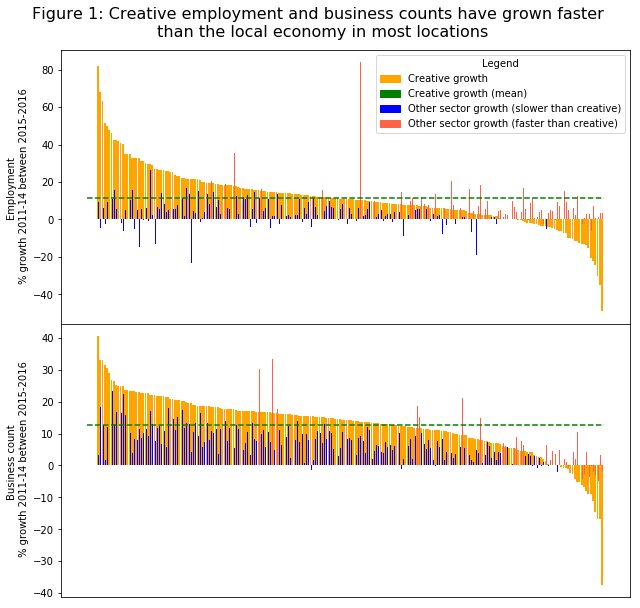

In [317]:
#Create a bar chart with heights = changes (comparing creative growth with other growth) for
#employment and business counts

#Sort both datasets
growth_empl,growth_bc = [x.sort_values('creative_growth',ascending=False) for x in [growth_empl,growth_bc]]

#Initialise plot
fig, ax = plt.subplots(nrows=2,figsize=(9,8),sharex=True)

#Plot employment
for location in np.arange(len(growth_empl)):
    #This plots creative growth
    ax[0].bar(location,height=100*growth_empl.iloc[location]['creative_growth']-100,bottom=0,
              color='orange',
              linewidth=0.8)

    #This plots growth in other sectors using a thinner bar
    ax[0].bar(location+0.3,height=100*growth_empl.iloc[location]['other_growth']-100,bottom=0,
              color='blue' if growth_empl.iloc[
                  location]['creative_growth']> growth_empl.iloc[location]['other_growth'] else 'tomato',
              
              width=0.4,
              edgecolor='grey',
              linewidth=0.01)
    
    #This is a hline with the UK mean
ax[0].hlines(y=100*np.mean(growth_empl.creative_growth)-100,xmin=-5,xmax=len(growth_empl),color='green',linestyle='--')

#Y label
ax[0].set_ylabel('Employment \n % growth 2011-14 between 2015-2016')

#Plot business counts (same as above)
for location in np.arange(len(growth_bc)):
    ax[1].bar(location,height=100*growth_bc.iloc[location]['creative_growth']-100,bottom=0,
              color='orange',
              linewidth=0.8
             )
    ax[1].bar(location+0.3,height=100*growth_bc.iloc[location]['other_growth']-100,bottom=0,
              color='blue' if growth_bc.iloc[
                  location]['creative_growth']> growth_bc.iloc[location]['other_growth'] else 'tomato',
              
              width=0.4,
              edgecolor='grey',
              linewidth=0.01)
    
ax[1].hlines(y=100*np.mean(growth_bc.creative_growth)-100,xmin=-5,xmax=len(growth_empl),color='green',linestyle='--')

#Y label
ax[1].set_ylabel('Business count \n % growth 2011-14 between 2015-2016')


#Remove ticklabels (they don't make much sense here)
ax[1].set_xticklabels(['' for x in ax[1].get_yticklabels()])
ax[1].set_xticklabels(['' for x in ax[1].get_yticklabels()])


#Custom legends
patches = [ mpatches.Patch(color=c, 
                           label=i) for c,i in zip(['orange','green','blue','tomato'],
                                                   ['Creative growth',
                                                    'Creative growth (mean)',
                                                    'Other sector growth (slower than creative)',
                                                    'Other sector growth (faster than creative)'])]

ax[1].legend(handles=patches,
             bbox_to_anchor=(1,2),
             title='Legend')


plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.tick_params(axis='x',bottom='off')



fig.suptitle(
    'Figure 1: Creative employment and business counts have grown faster \n than the local economy in most locations',y=1.05,fontsize=16)

plt.savefig(fig_path+'/{date}_figure_1_growth.pdf'.format(date=today_str),bbox_inches='tight')


In [21]:
# What's the location with the vast increase in 'other sector activity'?
#It's Worksop and retford
growth_chart_emp.loc[growth_empl.other_growth.idxmax()]

creative_growth        1.105583
other_growth           1.838806
creative_emp         500.000000
other_emp          92400.000000
emp_share              0.005382
Name: Worksop and Retford, dtype: float64

In [22]:
#The Frontier economics data shows a big jump in activity in Worksop and Telford
idbr_frontier.loc[(idbr_frontier.ttwa_name=='Worksop and Retford') & (idbr_frontier.industry=='not_creative'),]

,business_count,employment,industry,ttwa_code,ttwa_name,year
1451,4132.500000,92400.0,not_creative,E30000291,Worksop and Retford,2015_2016
3415,3785.714286,50250.0,not_creative,E30000291,Worksop and Retford,2011_2014


In [23]:
#What locations have seen big creative declines? Most of them are small although there are some exceptions
#such as Petersborough and Dunfermline and Kirkcaldy

growth_chart_emp.sort_values('creative_growth').head(n=10)

,creative_growth,other_growth,creative_emp,other_emp,emp_share
ttwa_name,,,,,
Bridlington,0.510367,1.035215,80.0,9015.0,0.008796
Liskeard,0.651369,1.032568,220.0,13950.0,0.015526
Peterborough,0.696097,1.011983,12985.0,178090.0,0.067958
Thurso,0.754717,1.009811,20.0,4460.0,0.004464
Golspie and Brora,0.776699,1.071845,20.0,2300.0,0.008621
Chesterfield,0.795940,0.936624,1490.0,250480.0,0.005913
Huddersfield,0.849958,1.027593,2780.0,134440.0,0.020259
Turriff and Banff,0.862745,1.029882,55.0,7295.0,0.007483
Dunfermline and Kirkcaldy,0.866641,1.009308,1675.0,88670.0,0.018540


In [24]:
#Most
growth_chart_bc.sort_values('creative_growth').head(n=10)

,creative_growth,other_growth,creative_bc,other_bc,bc_share
ttwa_name,,,,,
Turriff and Banff,0.625000,0.981667,15.0,1472.5,0.010084
Ullapool,0.833333,0.951429,17.5,540.0,0.031390
Portree,0.833333,1.033333,15.0,600.0,0.024390
Bridlington,0.853659,0.968659,35.0,1527.5,0.022400
Dunoon and Rothesay,0.887097,0.980645,27.5,800.0,0.033233
Orkney Islands,0.909091,0.996667,30.0,1495.0,0.019672
Lochgilphead,0.909091,0.964432,20.0,517.5,0.037209
Peterhead,0.921053,1.040658,35.0,1797.5,0.019100
Pembroke and Tenby,0.932203,0.972542,55.0,1510.0,0.035144


#### Some statistics for the report

In [322]:
#Median growth in creative vs other sectors

100*(growth_empl.mean())-100

other_growth        5.475702
creative_growth    11.522514
emp_share         -97.777776
dtype: float64

In [323]:
#Median growth inbusiness vs other sectors
100*(growth_bc.mean()-1)

other_growth        7.479600
creative_growth    12.644506
bc_share          -94.419469
dtype: float64

In [324]:
#Number of TTWAs with positive growth and with faster growth than the local economy
print(np.sum(growth_empl.creative_growth >1)/len(growth_chart_emp))
print(np.sum(growth_empl.creative_growth > growth_empl.other_growth)/len(growth_chart_emp))

0.825892857143
0.678571428571


In [326]:
#Number of TTWAs with positive business count growth and with faster growth than the local economy
print(np.sum(growth_bc.creative_growth >1)/len(growth_bc))
print(np.sum(growth_bc.creative_growth > growth_bc.other_growth)/len(growth_bc))

0.897321428571
0.830357142857


####  Regional TTWA growth chart

Now we will create a faceted chart with changes in employment by region.

In [29]:
#We will sort regions by their level of employment growth
#Estimate changes in employment by region
regional_employment_change = all_changes.loc[
    all_changes.sector=='All creative industries',:].groupby('region')['emp_abs_change'].sum().sort_values(ascending=False)

#These are regions names sorted by their employment growth
regions_sorted = regional_employment_change.index

#And this is what things look like. Well done Yorkshire and the Humber!
regional_employment_change

region
London                      76738.25
South East                  23877.25
Yorkshire and The Humber    11064.75
North West                  10937.50
West Midlands                9736.50
South West                   8093.50
East of England              5992.75
Scotland                     5399.00
East Midlands                4871.25
North East                   2722.75
Wales                        2261.50
Northern Ireland              522.00
Name: emp_abs_change, dtype: float64

In [30]:
#Combine employment and business growth tables
growth_emp_bc = pd.concat([growth_empl['creative_growth'],
                           growth_bc['creative_growth']],axis=1)

growth_emp_bc.columns=['creative_emp_growth','creative_bc_growth']
growth_emp_bc = 100*growth_emp_bc-1

In [31]:
#Create a chart with absolute changes in activity
absolute_changes = all_changes.loc[
    all_changes.sector=='All creative industries',:].reset_index(drop=True).set_index('ttwa_name').dropna()

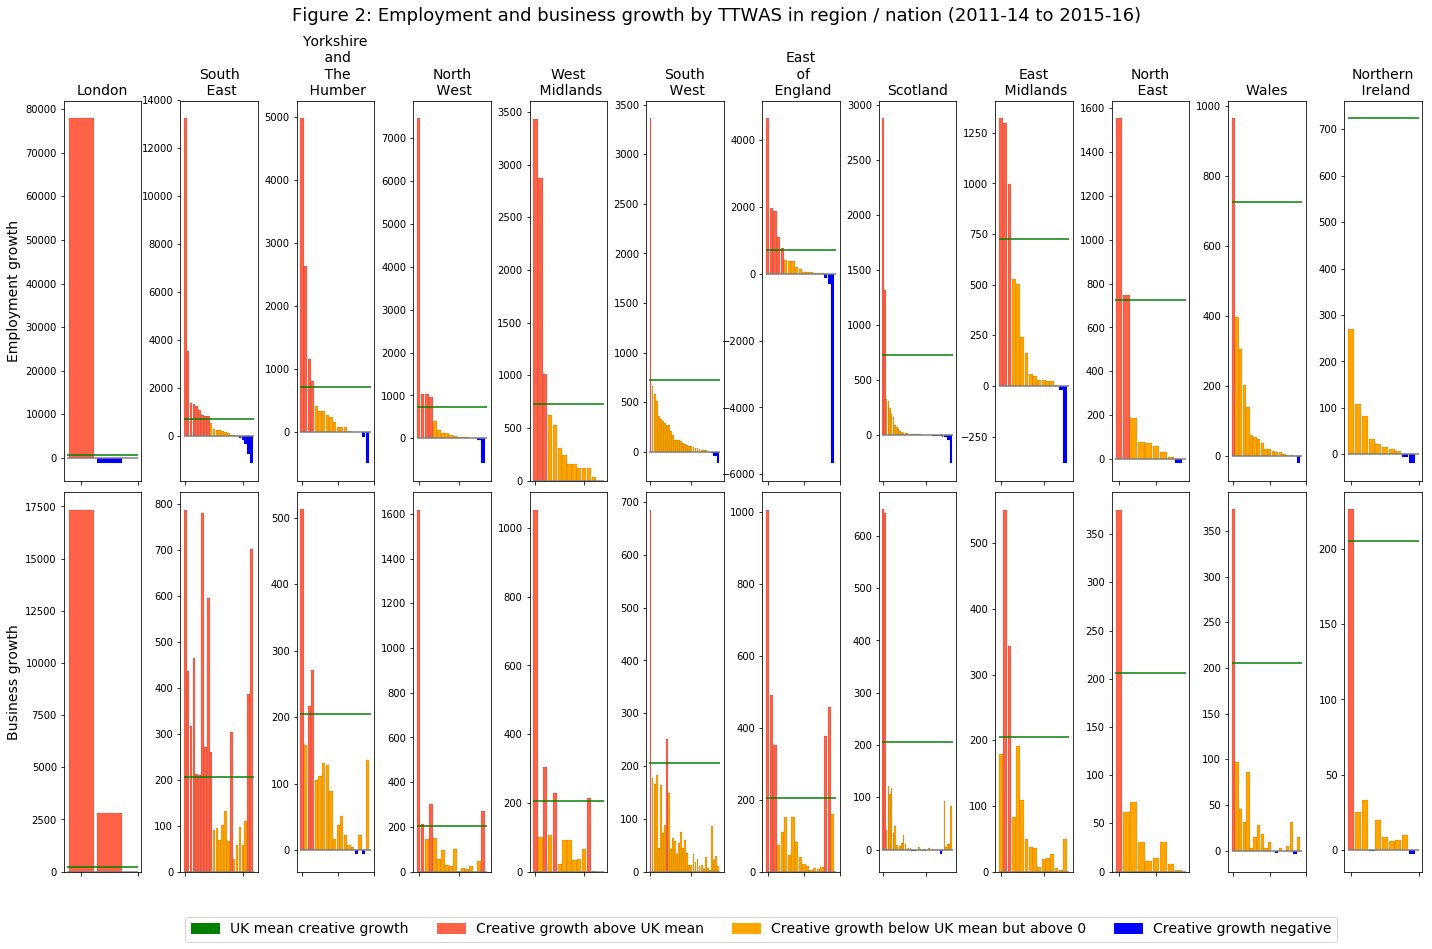

In [32]:
#Each column is a region
#Each column shares the X axis
fig,ax = plt.subplots(ncols=len(regions_sorted),nrows=2,figsize=(20,12),sharex='col')

#For each region we will create a barplot
for num, region in enumerate(regions_sorted):
    
    #Select TTWAs in region
    ttwas_in_region = [k for k,v in ttwa_region_lookup.items() if v==region and k in growth_emp_bc.index]
    
    #Subset the data
    reg_data = absolute_changes.loc[ttwas_in_region].sort_values('emp_abs_change',ascending=False)
    
    #For each TTWA in the data
    for num_2,ttwa in enumerate(reg_data.index):
    
    #Create the employment barplot. We colour bars depending on whether they are above the mean for the UK or not
        ax[0][num].bar(num_2,
                       reg_data.loc[ttwa]['emp_abs_change'],
                       color='tomato' if reg_data.loc[ttwa]['emp_abs_change']> np.mean(
                           absolute_changes['emp_abs_change']) else
                       'orange' if reg_data.loc[ttwa]['emp_abs_change']>0 else 'blue',
                       edgecolor='black',width=0.9,linewidth=0.1)

                
        ax[1][num].bar(num_2,
                       reg_data.loc[ttwa]['bc_abs_change'],
                       color='tomato' if reg_data.loc[ttwa]['bc_abs_change']> np.mean(
                           absolute_changes['bc_abs_change']) else
                       'orange' if reg_data.loc[ttwa]['bc_abs_change']>0 else 'blue',
                       edgecolor='black',width=0.9,linewidth=0.1)
   
    #Add some horizontal lines at zero and at the mean value
    ax[0][num].hlines(y=0,xmin=-0.5,xmax=len(reg_data),color='grey')
    ax[0][num].hlines(y=np.mean(absolute_changes['emp_abs_change']),xmin=-0.5,xmax=len(reg_data),color='green')
    
                
    ax[1][num].hlines(y=0,xmin=-0.5,xmax=len(reg_data),color='grey')
    ax[1][num].hlines(y=np.mean(absolute_changes['bc_abs_change']),xmin=-0.5,xmax=len(reg_data),color='green')
                            
    #Title for each subplot (region, which we split by spaces so everything fits nicely)
    ax[0][num].set_title("\n ".join(region.split(" ")),size=14)
    
    #Remove tick labels
    ax[1][num].set_xticklabels(['' for x in ax[1][num].get_yticklabels()])
    
ax[0][0].set_ylabel('Employment growth',size=14)
ax[1][0].set_ylabel('Business growth',size=14)

#Create custom legend
patch = [mpatches.Patch(color=x,label=var) for x,var in zip(['green','tomato','orange','blue'],
                                                            ['UK mean creative growth','Creative growth above UK mean',
                                                            'Creative growth below UK mean but above 0',
                                                            'Creative growth negative'])]
ax[1][6].legend(handles=patch,
                bbox_to_anchor=(7.5,-0.1),fontsize=14,ncol=4)

    
plt.tight_layout()
plt.subplots_adjust(hspace=0.03,wspace=0.5)

fig.suptitle('Figure 2: Employment and business growth by TTWAS in region / nation (2011-14 to 2015-16)',y=1.02,size=18)

plt.savefig(fig_path+'/{date}_figure_2_region_growth.pdf'.format(date=today_str),bbox_inches='tight')

In [333]:
pd.DataFrame({'order':np.arange(0,len(regions_sorted)),'region':regions_sorted})

,order,region
0,0,London
1,1,South East
2,2,Yorkshire and The Humber
3,3,North West
4,4,West Midlands
5,5,South West
6,6,East of England
7,7,Scotland
8,8,East Midlands
9,9,North East


In [378]:
#Table for the report
faster_growers = pd.merge(
    absolute_changes.loc[(absolute_changes.emp_abs_change>np.mean(absolute_changes.emp_abs_change)) & 
                                       (absolute_changes.bc_abs_change>np.mean(
                                           absolute_changes.bc_abs_change)),:].reset_index(drop=False),
    pd.DataFrame({'order':np.arange(0,len(regions_sorted)),'region':regions_sorted}),
    left_on='region',right_on='region').sort_values('emp_abs_change',ascending=False)


faster_growers = faster_growers[['ttwa_name','region','emp_abs_change','bc_abs_change']].reset_index(drop=True)
#faster_growers
faster_growers.columns = ['TTWA','Region / Nation','Employment change','Business count change']


faster_growers.to_csv(tab_path+'/{date}_table_1_locations.csv'.format(date=today_str),index=False)

#### Employment and business share chart

This creates some violinplots with the importance of the creative industries in different regions,
in terms of employment and business counts

In [33]:
#Create a df with the shares of activity
share_boxplot = pd.concat([100*growth_chart_emp['emp_share'],100*growth_chart_bc['bc_share']],axis=1).dropna()
share_boxplot['region'] = [ttwa_region_lookup[x] for x in share_boxplot.index]

In [34]:
#Create a list of regions sorted by the importance of the creative industries in the local economy
regions_sorted_box = share_boxplot.groupby('region')['emp_share'].median().sort_values(ascending=False).index

/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


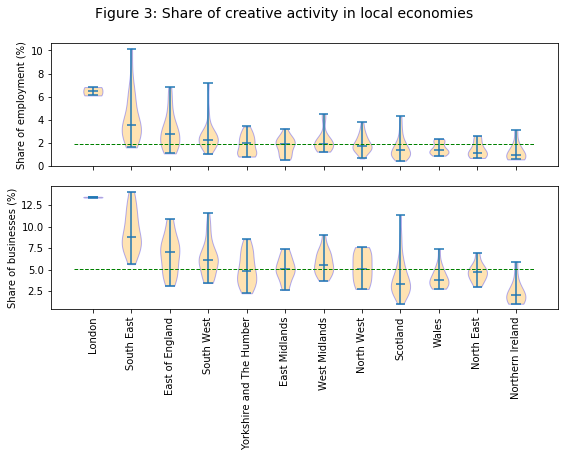

In [380]:
#Produce the violinplots
fig,ax = plt.subplots(nrows=2,figsize=(8,6),sharex=True)

#Create 2 lists with the TTWAs in each region
emp_data = [share_boxplot.loc[share_boxplot.region==x,'emp_share'] for x in regions_sorted_box]
bc_data = [share_boxplot.loc[share_boxplot.region==x,'bc_share'] for x in regions_sorted_box]

#Create the violinplots
vp_1 = ax[0].violinplot(emp_data,showmedians=True)
vp_2 = ax[1].violinplot(bc_data,showmedians=True)

#Add medians
ax[0].set_ylabel('Share of employment (%)')
ax[1].set_ylabel('Share of businesses (%)')

#Some customisation of the bodies of the violinplots
for x in [vp_1,vp_2]:
    for p in x['bodies']:
        p.set_facecolor('orange')
        p.set_edgecolor('blue')
    
#Set ticks and labels
ax[1].set_xticks([x+1 for x in np.arange(len(regions_sorted_box))])

#Add a couple of hlines with medians to compare regional and UK situations
ax[0].hlines(y=np.median(share_boxplot.emp_share),xmin=0.5,xmax=12.5,color='green',alpha=1,
             linewidth=1,
             linestyle='--')

ax[1].hlines(y=np.median(share_boxplot.bc_share),xmin=0.5,xmax=12.5,color='green',alpha=1,
             linewidth=1,
             linestyle='--')



ax[1].set_xticklabels(regions_sorted_box,rotation=90)

plt.tight_layout()

fig.suptitle('Figure 3: Share of creative activity in local economies',y=1.05,fontsize=14)

plt.savefig(fig_path+'/{date}_figure_3_violinplot.pdf'.format(date=today_str),bbox_inches='tight')


In [388]:
share_boxplot.groupby('region')[['emp_share','bc_share']].median()

,emp_share,bc_share
region,,
East Midlands,1.902302,5.083863
East of England,2.765957,7.071320
London,6.466940,13.416306
North East,1.076541,4.689655
North West,1.707680,5.014058
Northern Ireland,0.963050,2.053590
Scotland,1.405152,3.310105
South East,3.567617,8.815876
South West,2.248397,6.159515


In [387]:
share_boxplot.loc[['Edinburgh','Glasgow','Bath','Bristol']]

,emp_share,bc_share,region
ttwa_name,,,
Edinburgh,2.553778,11.319263,Scotland
Glasgow,2.930892,8.469688,Scotland
Bath,3.571172,11.616039,South West
Bristol,3.846331,10.226144,South West


### Fact 2: Concentration and growth

**Question**

* What TTWAs have grown and what TTWAs have declined? 
* Are the CIs becoming more or less concentrated? In what regions? In what sectors?



#### Create some maps (Choropleths) of specialisation

In [36]:
#Maps

#Here we are doing some geo-processing that we will also use for the neighbourhood analysis later

#Merge with shapefile attributes for ordering
changes_ord = pd.merge(pd.DataFrame(attr.by_col['TTWA11CD'],columns=['TTWA11CD']),
                   ttwas_coded,left_on='TTWA11CD',right_on='ttwa_code',how='outer',sort=False)

#Create df with only complete TTWAS and remove those from the weights
changes_ord_completes = changes_ord[[str(x)!="nan" for x in changes_ord.ttwa_code]]
ttwas_w_data = list(changes_ord_completes.index)

#Subset weights to focus on available TTWAs, and normalise
wsub = pysal.w_subset(w,ttwas_w_data)
wsub.transform='r'


('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 9, 166, 167, 168, 169
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [37]:
#Lookup between shapefiles indices and TTWAs
ttwa_index_name_lookup = {x:y for x,y in zip(changes_ord_completes.index,changes_ord_completes.ttwa_name)}

#Dict with the neighbours for each area (we will use this in the Geo analysis later)
neighbors_looked_up = {ttwa_index_name_lookup[x]:
                       [ttwa_index_name_lookup[item] for item in y] for x,y in wsub.neighbors.items()} 


In [38]:
#Some additional data processing to obtain the LQs by sector / area / year and their change

#NB this is a left merge which is ok (the sectoral TTWA has all the data)

#Employment LQs
empl_lqs = pd.pivot_table(pd.melt(
    pd.merge(empl_lqs_sectoral,
             empl_lqs_subsectoral,
             left_on=['year','ttwa_name'],
             right_on=['year','ttwa_name']),id_vars=['ttwa_name','year'],var_name='sector',value_name='emp_lq'),
                          index=['ttwa_name','sector'],columns='year',values='emp_lq').reset_index(drop=False)

empl_lqs.rename(columns={'2015_2016':'emp_lq_2015_2016','2011_2014':'emp_lq_2011_2014'},inplace=True)

empl_lqs['emp_lq_change'] = empl_lqs['emp_lq_2015_2016']/ empl_lqs['emp_lq_2011_2014']

#Business count LQs
bc_lqs = pd.pivot_table(pd.melt(
    pd.merge(bc_lqs_sectoral,
             bc_lqs_subsectoral,
             left_on=['year','ttwa_name'],
             right_on=['year','ttwa_name']),id_vars=['ttwa_name','year'],var_name='sector',value_name='bc_lq'),
                          index=['ttwa_name','sector'],columns='year',values='bc_lq').reset_index(drop=False)

bc_lqs.rename(columns={'2015_2016':'bc_lq_2015_2016','2011_2014':'bc_lq_2011_2014'},inplace=True)

bc_lqs['bc_lq_change'] = bc_lqs['bc_lq_2015_2016']/ bc_lqs['bc_lq_2011_2014']

In [39]:
#This is what they look like
empl_lqs.head()

year,ttwa_name,sector,emp_lq_2011_2014,emp_lq_2015_2016,emp_lq_change
0,Aberdeen,Advertising and marketing,0.196682,0.177621,0.903087
1,Aberdeen,All creative industries,0.472055,0.419550,0.888775
2,Aberdeen,Architecture,1.347541,0.976341,0.724536
3,Aberdeen,"Design: product, graphic and fashion design",0.583493,0.499222,0.855576
4,Aberdeen,"Film, TV, video, radio and photography",0.212652,0.166367,0.782346


In [40]:
bc_lqs.head()

year,ttwa_name,sector,bc_lq_2011_2014,bc_lq_2015_2016,bc_lq_change
0,Aberdeen,Advertising and marketing,0.271665,0.279145,1.027534
1,Aberdeen,All creative industries,0.507758,0.454761,0.895626
2,Aberdeen,Architecture,1.442507,1.221170,0.846561
3,Aberdeen,"Design: product, graphic and fashion design",0.536299,0.516202,0.962527
4,Aberdeen,"Film, TV, video, radio and photography",0.311943,0.260667,0.835623


In [41]:
#Combine LQ info
#NEED TO REVISIT AND TIDY READ IT

#bc_lqs_subsectoral_long = pd.pivot_table(pd.melt(bc_lqs_subsectoral.reset_index(drop=False),
#                                    id_vars=['ttwa_name','year'],var_name='sector'),index=['ttwa_name','sector'],
#                                           columns='year',values='value').reset_index(drop=False)

#bc_lqs_subsectoral_long.columns = ['ttwa_name','sector','bc_lq_2011_2014','bc_lq_2015_2016']

In [42]:
#Add employment totals
#Melt the empl totals variable we defined at the beginning
empl_long = pd.melt(empl_totals,id_vars=['ttwa_name','ttwa_code','year'],var_name='sector')
empl_long = empl_long.loc[empl_long.year=='2015_2016',:][['ttwa_name','sector','value']].set_index(
    ['ttwa_name','sector'])

#Concatenate the totals and rename columns
all_emp = pd.concat([empl_lqs.set_index(['ttwa_name','sector']),
                     empl_long],axis=1).reset_index(drop=False).set_index(['ttwa_name','sector'])

all_emp.rename(columns={'value':'emp_2015_2016'},inplace=True)

all_emp.head()

emp_lq_2011_2014  \
ttwa_name sector                                                          
Aberdeen  Advertising and marketing                            0.196682   
          All creative industries                              0.472055   
          Architecture                                         1.347541   
          Design: product, graphic and fashion design          0.583493   
          Film, TV, video, radio and photography               0.212652   

                                                       emp_lq_2015_2016  \
ttwa_name sector                                                          
Aberdeen  Advertising and marketing                            0.177621   
          All creative industries                              0.419550   
          Architecture                                         0.976341   
          Design: product, graphic and fashion design          0.499222   
          Film, TV, video, radio and photography               0.166367   

                                                       emp_lq_change  \
ttwa_name sector                                                       
Aberdeen  Advertising and marketing                         0.903087   
          All creative industries                           0.888775   
          Architecture                                      0.724536   
          Design: product, graphic and fashion design       0.855576   
          Film, TV, video, radio and photography            0.782346   

                                                       emp_2015_2016  
ttwa_name sector                                                      
Aberdeen  Advertising and marketing                            190.0  
          All creative industries                             3635.0  
          Architecture                                         495.0  
          Design: product, graphic and fashion design          205.0  
          Film, TV, video, radio and photography               205.0

In [43]:
#Do the same with business counts 
all_bc = pd.merge(bc_lqs,
                  bc_totals_long.loc[bc_totals_long.year=='2015_2016',
                                    ['industry','ttwa_name','business_count']],
                  left_on=['ttwa_name','sector'],
                  right_on=['ttwa_name','industry'])

all_bc.rename(columns={'business_count':'business_count_2015_2016'},inplace=True)
all_bc.head()

,ttwa_name,sector,bc_lq_2011_2014,bc_lq_2015_2016,bc_lq_change,industry,business_count_2015_2016
0,Aberdeen,Advertising and marketing,0.271665,0.279145,1.027534,Advertising and marketing,65.0
1,Aberdeen,All creative industries,0.507758,0.454761,0.895626,All creative industries,1247.5
2,Aberdeen,Architecture,1.442507,1.221170,0.846561,Architecture,182.5
3,Aberdeen,"Design: product, graphic and fashion design",0.536299,0.516202,0.962527,"Design: product, graphic and fashion design",110.0
4,Aberdeen,"Film, TV, video, radio and photography",0.311943,0.260667,0.835623,"Film, TV, video, radio and photography",82.5


In [44]:
#Combine all lqs
all_lqs = pd.concat([empl_lqs.set_index(['ttwa_name','sector']),
                   bc_lqs.set_index(['ttwa_name','sector'])],axis=1)

#Combine everything
all_data = pd.concat([all_changes.set_index(['ttwa_name','sector']),all_lqs],axis=1)

#Create another couple of variables we will use later
all_data['emp_growth'] = all_data['emp_2015_2016']-all_data['emp_2011_2014']

all_data['bc_growth'] = all_data['bc_2015_2016']-all_data['bc_2011_2014']

#Add regions
all_data['region'] = [ttwa_region_lookup[x] for x in all_data.reset_index(drop=False)['ttwa_name']]

In [45]:
#All data combines all the employment and business count data from above
all_data_to_merge = pd.concat([all_bc.set_index(['ttwa_name','sector']),
                                                all_emp],axis=1).reset_index(drop=False)

#Read the shapefile with the polygons for mapping
ttwa_shp_read = gp.read_file(shapefile_loc)

#Create merged TTWA
ttwa_merged = pd.merge(ttwa_shp_read,
                       all_changes.loc[
                           :,['ttwa_name','employment_change','emp_2015_2016','sector',
                             'business_change','bc_2015_2016']],
                       left_on='TTWA11NM',right_on='ttwa_name')

#We merge the LQ data
ttwa_lqs_merged = pd.merge(ttwa_shp_read,
                       all_data_to_merge,left_on='TTWA11NM',right_on='ttwa_name')

ttwa_lqs_merged.head()

,TTWA11CD,TTWA11NM,geometry,ttwa_name,sector,bc_lq_2011_2014,bc_lq_2015_2016,bc_lq_change,industry,business_count_2015_2016,emp_lq_2011_2014,emp_lq_2015_2016,emp_lq_change,emp_2015_2016
0,E30000004,Barnsley,"POLYGON ((436695.5939999996 413058.5950000007,...",Barnsley,Advertising and marketing,0.601536,0.675663,1.123230,Advertising and marketing,40.0,0.451325,0.398561,0.883092,135.0
1,E30000004,Barnsley,"POLYGON ((436695.5939999996 413058.5950000007,...",Barnsley,All creative industries,0.628079,0.638252,1.016197,All creative industries,445.0,0.553725,0.535856,0.967729,1470.0
2,E30000004,Barnsley,"POLYGON ((436695.5939999996 413058.5950000007,...",Barnsley,Architecture,0.636516,0.526377,0.826966,Architecture,20.0,0.343551,0.186870,0.543936,30.0
3,E30000004,Barnsley,"POLYGON ((436695.5939999996 413058.5950000007,...",Barnsley,"Design: product, graphic and fashion design",0.773174,0.738314,0.954913,"Design: product, graphic and fashion design",40.0,0.675793,0.576796,0.853510,75.0
4,E30000004,Barnsley,"POLYGON ((436695.5939999996 413058.5950000007,...",Barnsley,"Film, TV, video, radio and photography",0.476927,0.528171,1.107446,"Film, TV, video, radio and photography",42.5,0.408283,0.410067,1.004369,160.0


In [46]:
#Create a list of sorted sectors to arrange the maps
sector_totals = all_data.reset_index(
    drop=False).groupby('sector')['emp_2015_2016'].sum().sort_values(ascending=False)
sectors_sorted = sector_totals.index[1:]

All creative industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services
Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Design: product, graphic and fashion design


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


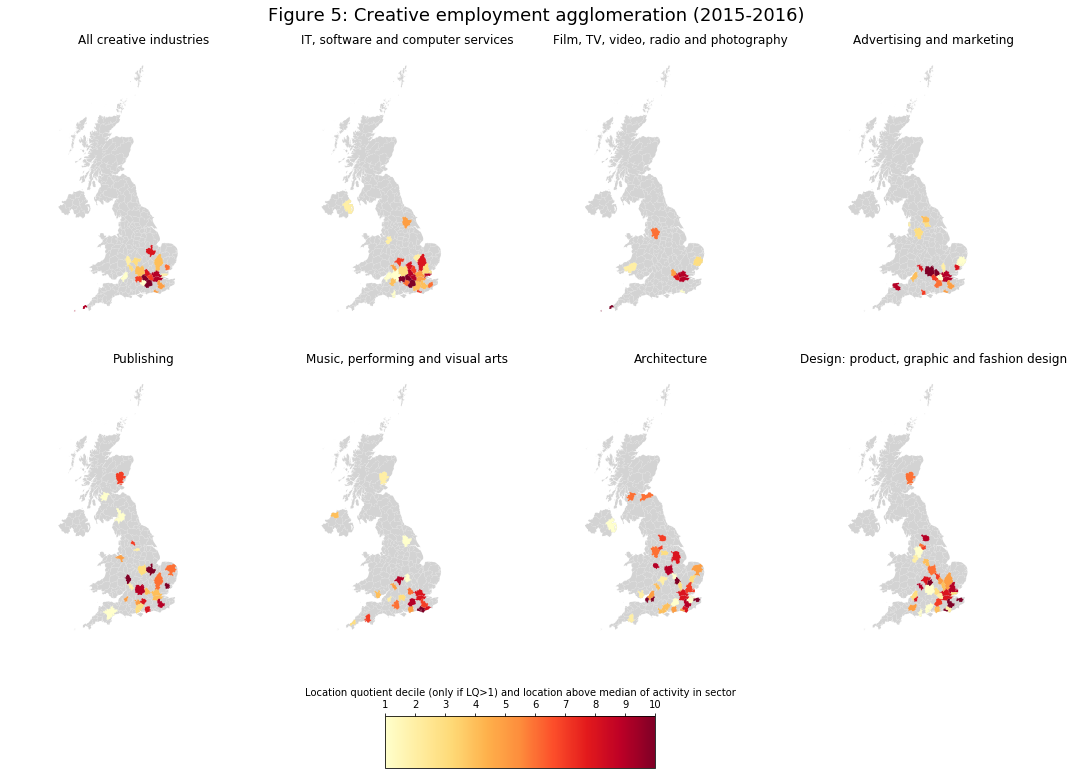

In [422]:
#Creaye the map
fig,ax = plt.subplots(ncols=4,
                     nrows=2,figsize=(15,9))


#For each sectora
for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector (to keep track of things)
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<4 else num-4
    row = 0 if num<4 else 1
    
    #We use the function we defined previously
    m = cluster_map(df=ttwa_lqs_merged,
                    sector=x,
                    esp_var='emp_lq_2015_2016',
                    act_var='emp_2015_2016',
                    ax=ax[row][col],threshold=0.5,
                    my_cmap='YlOrRd')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar

#Add axes
cbar_ax = fig.add_axes([0.36, -0.15, 0.25, 0.08])

norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='YlOrRd',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Location quotient decile (only if LQ>1) and location above median of activity in sector')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')


fig.suptitle('Figure 5: Creative employment agglomeration (2015-2016)',y=1.025,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_figure_5_clustering_maps.pdf'.format(date_today=today_str),bbox_inches='tight')


All creative industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services
Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Design: product, graphic and fashion design


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


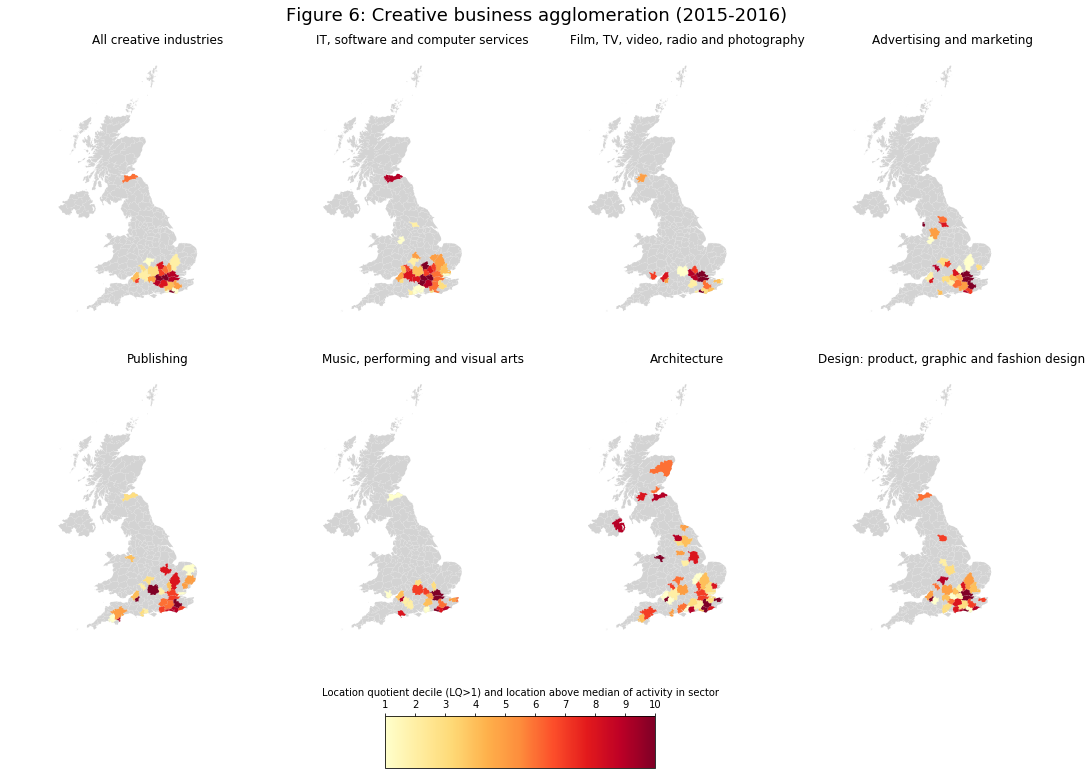

In [423]:
#Create a map of subsectoral agglomeration in business count
fig,ax = plt.subplots(ncols=4,
                     nrows=2,figsize=(15,9))

#It's the same as above but with different variables
for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<4 else num-4
    row = 0 if num<4 else 1
    
    cluster_map(df=ttwa_lqs_merged,
                sector=x,
                esp_var='bc_lq_2015_2016',
                act_var='business_count_2015_2016',threshold=0.5,
                ax=ax[row][col],
                my_cmap='YlOrRd')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar
plt.subplots_adjust(hspace=0.1,wspace=0.01)

#Add axes
cbar_ax = fig.add_axes([0.36, -0.15, 0.25, 0.08])

norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='YlOrRd',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Location quotient decile (LQ>1) and location above median of activity in sector')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')


fig.suptitle('Figure 6: Creative business agglomeration (2015-2016)',y=1.025,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_figure_6_bc_clustering_maps.pdf'.format(date_today=today_str),bbox_inches='tight')

#### Change in concentration figure

In this chart we will visualise concentration of activity (top chart) and how it has changed between 
2011-14 and 2015-16 (bottom chart)


In [49]:
sectors_sorted_2 = ['not_creative']+list(sectors_sorted[::-1])

In [50]:
#####
#Data input
#####

#We focus on these breaks
my_breaks=[0,1,5,10,25,50,100]

#Data inputs for the chart
#Extract 2016 distributions of employment and business numbers for the top of the chart
distributions_16_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2015_2016'],
                        variable='emp_2015_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)

#Business
distributions_16_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2015_2016'],variable='bc_2015_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)

#Extract 2015 distributions (which we will use to look at changes)
distributions_15_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2011_2014'],variable='emp_2011_2014',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)
#And business.
distributions_15_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2011_2014'],variable='bc_2011_2014',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)


#This is what one of these looks like

distributions_16_emp

,not_creative,"Design: product, graphic and fashion design",Architecture,"Music, performing and visual arts",Publishing,Advertising and marketing,"Film, TV, video, radio and photography","IT, software and computer services",All creative industries
bins,,,,,,,,,
"[0, 1)",0.207394,0.349602,0.355904,0.440062,0.414849,0.498866,0.598979,0.277723,0.384082
"[1, 5)",0.321814,0.461641,0.476988,0.550275,0.585348,0.629877,0.777095,0.495804,0.537250
"[5, 10)",0.403329,0.538720,0.561598,0.620860,0.690322,0.722160,0.822504,0.592074,0.613087
"[10, 25)",0.575443,0.694209,0.713156,0.759170,0.855591,0.829973,0.889883,0.755689,0.754848
"[25, 50)",0.735978,0.829888,0.842622,0.871046,0.940441,0.921521,0.944336,0.877077,0.870601
"[50, 100)",0.897614,0.955551,0.962111,0.964313,0.992081,0.985333,0.987850,0.974363,0.958795


In [51]:
#Changes

#We combine 2016-15 employments to extract changes in concentration
emp_conc_change = pd.concat([pd.melt(distributions_16_emp.reset_index(drop=False),id_vars='bins',
                                     value_name='emp_2015_2016',
                                    var_name='variable_2015_2016'),
           pd.melt(distributions_15_emp.reset_index(drop=False),id_vars='bins',value_name='emp_2011_2014',
                  var_name='variable_2011_2014')],axis=1)

emp_conc_change['change'] = 100*(emp_conc_change['emp_2015_2016']/emp_conc_change['emp_2011_2014'] -1)

#Widen for plotting
emp_conc_wide = pd.pivot_table(emp_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2015_2016',values='change')

#Same with the business counts
bc_conc_change = pd.concat([pd.melt(distributions_16_bc.reset_index(drop=False),
                                        id_vars='bins',value_name='bc_2015_2016',
                                    var_name='variable_2015_2016'),
           pd.melt(distributions_15_bc.reset_index(drop=False),id_vars='bins',value_name='bc_2011_2014',
                  var_name='variable_2011_2014')],axis=1)

bc_conc_change['change'] = 100*(bc_conc_change['bc_2015_2016']/bc_conc_change['bc_2011_2014']-1)

#And widen
bc_conc_wide = pd.pivot_table(bc_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2015_2016',values='change')

#A look at the data
emp_conc_wide

variable_2015_2016,Advertising and marketing,All creative industries,Architecture,"Design: product, graphic and fashion design","Film, TV, video, radio and photography","IT, software and computer services","Music, performing and visual arts",Publishing,not_creative
bins,,,,,,,,,
"[0, 1)",7.321670,3.829854,5.944382,9.137738,3.795220,11.337529,1.784285,3.250106,3.850774
"[1, 5)",1.676322,1.573414,5.626496,8.277264,0.885535,3.579522,0.684630,-3.235631,1.828026
"[5, 10)",2.758829,1.049645,5.887038,8.321501,0.912086,2.711949,1.178563,-1.351049,0.907247
"[10, 25)",2.755400,0.354923,4.520964,5.522625,0.785218,1.623358,2.263099,2.975078,0.897012
"[25, 50)",1.829251,0.359068,3.785985,4.138332,1.145996,1.144094,2.373685,2.693641,0.135450
"[50, 100)",1.178269,0.185612,3.509938,3.029610,1.150517,0.912755,2.473157,1.853523,0.237840


In [52]:
#Labels for the X axis
conc_labels = ['Largest location','5 largest','10 largest ','25 largest','50 largest','100 largest']


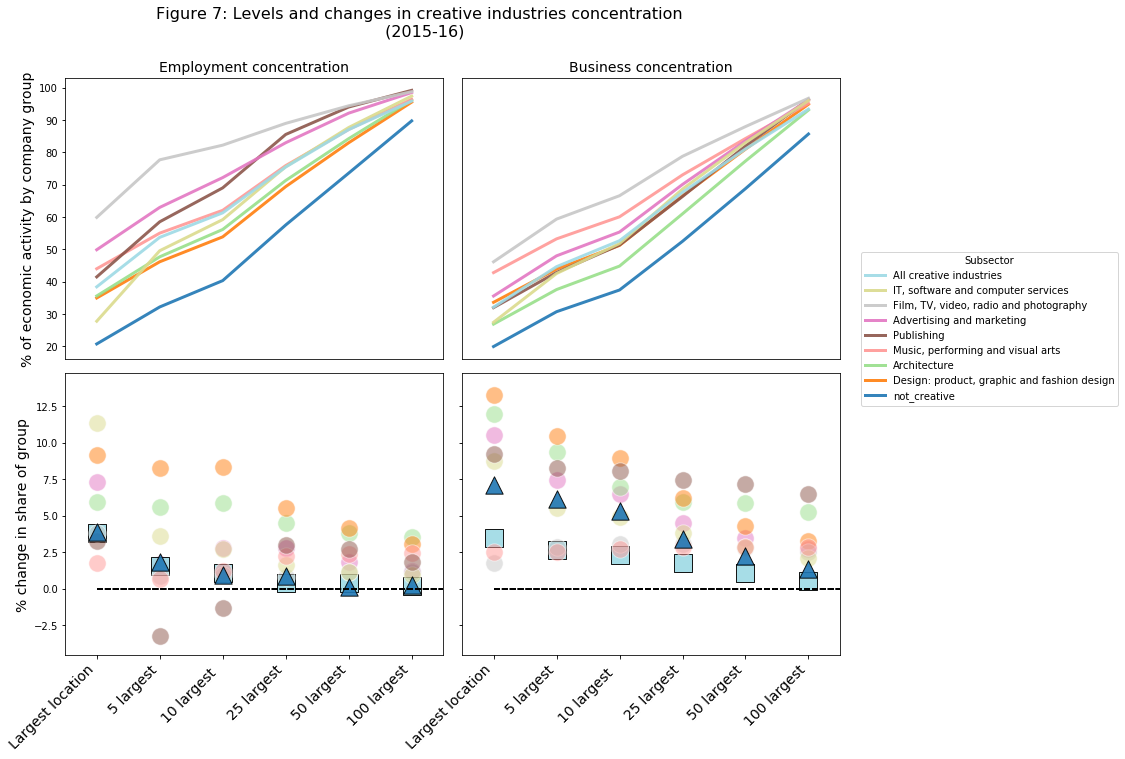

In [424]:
#####
#PLOT
#####

fig,ax = plt.subplots(figsize=(12,10),ncols=2,nrows=2,
                      sharex='col',
                      sharey='row')

#Plot employment concentrations
(100*distributions_16_emp).plot(ax=ax[0][0],linewidth=3,alpha=0.9,colormap='tab20')
ax[0][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][0].set_xticks(np.arange(len(distributions_16_emp)))

#Titles
ax[0][0].set_title('Employment concentration',fontsize=14)
ax[0][0].set_ylabel('% of economic activity by company group',fontsize=14)

#Remove the ticks for the x
ax[0][0].tick_params(axis='x', which='both', length=0)


#We will only use this legend. NN we displace it from its anchor so it's on the side, and
#we flip the order of the labels so that we have more concentrated categories at the top.

#This takes the handles and labels generated by matplotlib and allows us to modify them.
handles,labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(bbox_to_anchor=[2.8,0.4],handles=handles[::-1],labels=labels[::-1],title='Subsector')

#Plot the business distributions
(100*distributions_16_bc).plot(ax=ax[0][1],linewidth=3,alpha=0.9,colormap='tab20')
ax[0][1].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][1].set_title('Business concentration',fontsize=14)
ax[0][1].set_xticks(np.arange(len(distributions_16_bc)))

#Remove all the ticks
ax[0][1].tick_params(axis='both', which='both', length=0)

#We make the legend invisible
ax[0][1].legend().set_visible(False)

#Get lines to label the colours below
lines = ax[0][1].get_lines()

#Create a lookup so we know what colour goes with every line. We then use it to colour the circles below.
lines_colors_lookup = {x.get_label():x.get_color() for x in lines}

#Draw the employment scatter
#Loop over every sector and draw it in the scatter
for x in np.arange(0,len(sectors_sorted_2[::-1])):
    
    #We have a lower alpha for the creative industries category (we want it to be more visible)
    ax[1][0].scatter(np.arange(len(emp_conc_wide)),emp_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[emp_conc_wide.columns[x]],
                     marker = 's' if emp_conc_wide.columns[x] =='All creative industries' else '^' if emp_conc_wide.columns[x] =='not_creative' else 'o',
                     edgecolor='white' if emp_conc_wide.columns[x] not in [
                         'All creative industries','not_creative'] else 'black',
                     s=300,alpha=0.5 if emp_conc_wide.columns[x] not in ['not_creative','All creative industries'] else 0.9)
    ax[1][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
    ax[1][0].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][0].set_ylabel('% change in share of group',fontsize=14)
    ax[1][0].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_emp))],rotation=45,ha='right',
                            fontsize=14)
    
#Draw the business count scatter
for x in np.arange(len(emp_conc_wide.columns)):
    ax[1][1].scatter(np.arange(len(bc_conc_wide)),bc_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[bc_conc_wide.columns[x]],
                     marker = 's' if bc_conc_wide.columns[x] =='All creative industries' else '^' if bc_conc_wide.columns[x] =='not_creative' else 'o',
                     edgecolor='white' if bc_conc_wide.columns[x] not in [
                         'All creative industries','not_creative'] else 'black',
                     s=300,alpha=0.5 if bc_conc_wide.columns[x] not in ['All creative industries','not_creative'] else 0.9)
    ax[1][1].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][1].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_bc))],rotation=45,ha='right',
                            fontsize=14)
    

#Title above. NB the y we use to 
fig.suptitle('Figure 7: Levels and changes in creative industries concentration \n (2015-16)',y=1.05,fontsize=16)

#Tight layout 
plt.tight_layout()

#Adjust subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(fig_path+'/{today_str}_figure_7_concentration.pdf'.format(today_str=today_str),bbox_inches='tight')

In [406]:
distributions_16_emp

,not_creative,"Design: product, graphic and fashion design",Architecture,"Music, performing and visual arts",Publishing,Advertising and marketing,"Film, TV, video, radio and photography","IT, software and computer services",All creative industries
bins,,,,,,,,,
"[0, 1)",0.207394,0.349602,0.355904,0.440062,0.414849,0.498866,0.598979,0.277723,0.384082
"[1, 5)",0.321814,0.461641,0.476988,0.550275,0.585348,0.629877,0.777095,0.495804,0.537250
"[5, 10)",0.403329,0.538720,0.561598,0.620860,0.690322,0.722160,0.822504,0.592074,0.613087
"[10, 25)",0.575443,0.694209,0.713156,0.759170,0.855591,0.829973,0.889883,0.755689,0.754848
"[25, 50)",0.735978,0.829888,0.842622,0.871046,0.940441,0.921521,0.944336,0.877077,0.870601
"[50, 100)",0.897614,0.955551,0.962111,0.964313,0.992081,0.985333,0.987850,0.974363,0.958795


In [54]:
distributions_16_emp.iloc[:2,:]

,not_creative,"Design: product, graphic and fashion design",Architecture,"Music, performing and visual arts",Publishing,Advertising and marketing,"Film, TV, video, radio and photography","IT, software and computer services",All creative industries
bins,,,,,,,,,
"[0, 1)",0.207394,0.349602,0.355904,0.440062,0.414849,0.498866,0.598979,0.277723,0.384082
"[1, 5)",0.321814,0.461641,0.476988,0.550275,0.585348,0.629877,0.777095,0.495804,0.537250


In [55]:
distributions_16_bc.iloc[:2,:]

,not_creative,"Design: product, graphic and fashion design",Architecture,"Music, performing and visual arts",Publishing,Advertising and marketing,"Film, TV, video, radio and photography","IT, software and computer services",All creative industries
bins,,,,,,,,,
"[0, 1)",0.199333,0.336162,0.268717,0.428063,0.319733,0.355688,0.461586,0.274431,0.321256
"[1, 5)",0.307118,0.439122,0.375651,0.532481,0.428537,0.479996,0.593621,0.425274,0.446472


In [56]:
emp_conc_change

,bins,variable_2015_2016,emp_2015_2016,bins,variable_2011_2014,emp_2011_2014,change
0,"[0, 1)",not_creative,0.207394,"[0, 1)",not_creative,0.199704,3.850774
1,"[1, 5)",not_creative,0.321814,"[1, 5)",not_creative,0.316036,1.828026
2,"[5, 10)",not_creative,0.403329,"[5, 10)",not_creative,0.399702,0.907247
3,"[10, 25)",not_creative,0.575443,"[10, 25)",not_creative,0.570327,0.897012
4,"[25, 50)",not_creative,0.735978,"[25, 50)",not_creative,0.734982,0.135450
5,"[50, 100)",not_creative,0.897614,"[50, 100)",not_creative,0.895484,0.237840
6,"[0, 1)","Design: product, graphic and fashion design",0.349602,"[0, 1)","Design: product, graphic and fashion design",0.320331,9.137738
7,"[1, 5)","Design: product, graphic and fashion design",0.461641,"[1, 5)","Design: product, graphic and fashion design",0.426351,8.277264
8,"[5, 10)","Design: product, graphic and fashion design",0.538720,"[5, 10)","Design: product, graphic and fashion design",0.497334,8.321501
9,"[10, 25)","Design: product, graphic and fashion design",0.694209,"[10, 25)","Design: product, graphic and fashion design",0.657877,5.522625


In [411]:
conc_stat_report = emp_conc_change.loc[(emp_conc_change.variable_2015_2016=='All creative industries')].reset_index(drop=True).iloc[:3]

conc_stat_report ['change']/conc_stat_report['emp_2011_2014']


0    10.353345
1     2.974723
2     1.730036
dtype: float64

#### Changes in concentration of activity by region

Here we create a barplot that considers concentration and changes in concentration of activity by region 



In [58]:
#Create a dataframe with changes in concentration by sector, region and year
activity_concentration = all_changes.loc[
    [x in ['All creative industries','not_creative'] for x in all_changes.sector],
    ['ttwa_name','region','sector','emp_2011_2014','emp_2015_2016','bc_2011_2014','bc_2015_2016']].reset_index(drop=True)

#Estimate shares of activity by TTWA in each region and sector
activity_shares_region = activity_concentration.groupby(
    ['region','sector'])[['emp_2011_2014','emp_2015_2016',
                          'bc_2011_2014','bc_2015_2016']].apply(lambda x: 100*x/x.sum())

#Extract columns
activity_shares_region.columns = [x+'_shares' for x in activity_shares_region.columns]

#Concatenate
activity_concentration = pd.concat([activity_concentration,activity_shares_region],axis=1).dropna()

In [59]:
#We want to lay down the charts in decreasing order of concentration.
region_mean_c = activity_concentration.groupby('region')['emp_2015_2016_shares','bc_2015_2016_shares'].max().mean(axis=1)
sorted_regions = region_mean_c.dropna().sort_values(ascending=False).index
sorted_regions

Index(['London', 'Northern Ireland', 'North East', 'North West', 'Wales',
       'West Midlands', 'Scotland', 'Yorkshire and The Humber',
       'East Midlands', 'South West', 'East of England', 'South East'],
      dtype='object', name='region')

In [60]:
def region_share_comp(var,region,ax):
    '''
    This function takes a region from activity and creates a barcharts comparing the variable
    in cis and other sectors
    
    
    '''
    #Extract region
    #print(region)
    reg = activity_concentration.loc[activity_concentration.region==region,:]
    
    
    #Extract data for variables and change names (this would be much easier if we put data in a tidy format)
    creat = reg.loc[reg.sector=='All creative industries',var].sort_values(ascending=False).reset_index(drop=True)
    creat.name=var+'_creative'
    
    not_creat = reg.loc[reg.sector=='not_creative',var].sort_values(ascending=False).reset_index(drop=True)
    
    not_creat.name = var+'_not_creative'
    
    #Concatenate variables
    var_mix = pd.concat([creat,not_creat],axis=1)

    for num,x in enumerate(var_mix.columns):
    #Select data
        data = var_mix[x]
        
        #Create color map

        reds = mpl.cm.OrRd

        #We rescale the data to assign the right color to each variable
        descaled_data = descale(data,0,200)
        

        #Extract colors in a list we can then select
        colors = [reds(int(x)) for x in descaled_data]
        
        #Bottom of the barchart
        bot=0
        #Stack the vars
        for z in np.arange(len(var_mix.index)):
            ax.bar(x=num,height=data.loc[z],bottom=bot,color=colors[z],alpha=0.9,edgecolor='white',linewidth=1.3)
            bot=bot+data.loc[z]
            
    #And we also want to draw a plot that connects all the lines
    
    bot_0=0
    bot_1=0
    
    for z in np.arange(len(var_mix)):
        ax.plot([0,1],[var_mix.iloc[z,0]+bot_0,
                       var_mix.iloc[z,1]+bot_1],color='black',marker='o',alpha=0.3)
        
        bot_0 = var_mix.iloc[z,0]+bot_0
        bot_1 = var_mix.iloc[z,1]+bot_1
    
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Creative industries','Other sectors'],rotation=90)
    
    #ax.set_title(region)
    

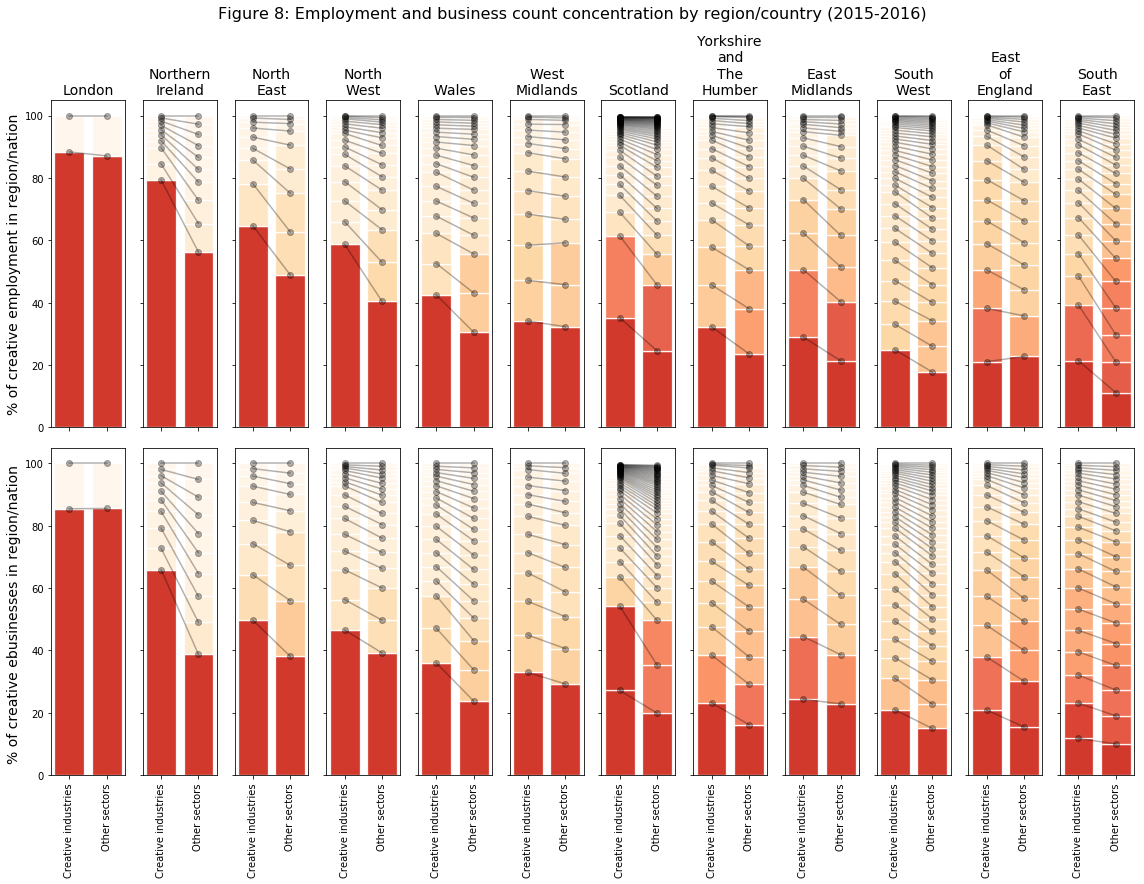

In [425]:
#Drwa figure using the function defined above
fig,ax = plt.subplots(nrows=2,ncols=len(set((sorted_regions))),figsize=(16,12),
                     sharey='row',sharex='col')

for num,reg in enumerate(sorted_regions):
    
    
    region_share_comp('emp_2015_2016_shares',reg,ax[0][num])
    
    region_share_comp('bc_2015_2016_shares',reg,ax[1][num])
    
    #Split the region titles to fit them nicely
    ax[0][num].set_title("\n".join([x for x in reg.split(" ")]),fontsize=14)
    
#Add labels
ax[0][0].set_ylabel('% of creative employment in region/nation',fontsize=14)
ax[1][0].set_ylabel('% of creative ebusinesses in region/nation ',fontsize=14)
    
fig.suptitle('Figure 8: Employment and business count concentration by region/country (2015-2016)',y=1.02,fontsize=16)
    
plt.tight_layout()

plt.savefig(fig_path+'/{date}_figure_8_intra_regional_concentration.pdf'.format(date=today_str),bbox_inches='tight')


### Fact 3: Size and productivity analysis

Here we will create a chart with size and productivity statistics regionally based on the ABS data, and produce some estimates of UK productivity growth assuming different growth scenarios for the creative industries and their productivity

Differently from what we did before, this analysis focuses on 2015-2016 and does not include Northern Ireland,
for which we don't have ABS data


In [552]:
#Business counts per sizeband/ region

#Sizebands
#Add region names

idbr_sizebands['region'] = [ttwa_region_lookup[x] for x in idbr_sizebands['ttwa_name']]

#Sum over regions for creative & non-creative sectors
idbr_regions_sizeb = idbr_sizebands.loc[[x in ['creative_industries','not_in_sector'] for x in idbr_sizebands.sector],
                                        ['sector','sizeband','value','year','region']].groupby([
    'region','sector','sizeband','year'])['value'].sum().reset_index(drop=False)

#Calculate the share of sizeband in total business by year and sector

#Pivot to put the years into columns
piv = pd.pivot_table(idbr_regions_sizeb,index=[x for x in idbr_regions_sizeb.columns if x not in['year','value']],
                                       columns='year',values='value').reset_index(drop=False)

#Extract the share. NB we zip a list of years for which we want the shares and years which we want to drop
#from the analysis
#NB we are converting the years to financial (rather than nominal)
piv['sizeband_share_2015'],piv['sizeband_share_2016']  = [get_share_over_variable(piv,x,drop=y,
                                                                                   grouper='sizeband') 
                                                          for x,y in zip([2016,2017],[2017,2016])]

#Growth in the share of a sizeband between years
piv['sizeband_share_growth'] = piv['sizeband_share_2016']/piv['sizeband_share_2015']

#Absolute growth in the sizeband
piv['sizeband_abs_growth'] = piv[2017]-piv[2016]

#Compare share in ci vs share out
piv_comp = pd.pivot_table(piv[['region','sector','sizeband','sizeband_share_2016']],
                          index=['region','sizeband'],
                          columns='sector',values='sizeband_share_2016')

#How do the creative - non creative sizeband shares compare?
piv_comp['c_v_non_c_share'] = piv_comp['creative_industries']/piv_comp['not_in_sector']

piv_all = pd.concat([piv.loc[piv.sector=='creative_industries',:].set_index(['region','sizeband']),piv_comp],axis=1)

piv_final = piv_all.reset_index(drop=False)[['region','sizeband','sizeband_share_2016',
                                             'sizeband_share_growth','sizeband_abs_growth',
                                             'c_v_non_c_share']]
piv_final.fillna(1,inplace=True)

sizeband_names_lookup = {x:x.split(" ")[0].lower() for x in set(piv_final.sizeband)}

piv_final['size_short'] = [sizeband_names_lookup[x] for x in piv_final.sizeband]

sizes_sorted = ['micro','small','medium-sized','large']

#Here is the thing
piv_final.head()

,region,sizeband,sizeband_share_2016,sizeband_share_growth,sizeband_abs_growth,c_v_non_c_share,size_short
0,East Midlands,Large (250+),0.000000,1.000000,0,0.000000,large
1,East Midlands,Medium-sized (50 to 249),0.004655,1.144120,10,0.195832,medium-sized
2,East Midlands,Micro (0 to 9),0.945832,0.999608,710,1.123473,micro
3,East Midlands,Small (10 to 49),0.049513,0.995668,35,0.374709,small
4,East of England,Large (250+),0.000201,0.966432,0,0.124937,large


In [553]:
#Also transform GVA data

gva_pivoted = pd.pivot_table(gva,index=['Region','Employment size band'],
                          columns='Industry',values='GVA per employee').reset_index(drop=False)
gva_pivoted['comp_prod'] = gva_pivoted['Creative']/ gva_pivoted['Other or unknown']

#Rename Yorkshire...
gva_pivoted['Region'] = [x if x.split(" ")[0]!='Yorkshire' else 'Yorkshire and The Humber' for x in gva_pivoted['Region']]

accent_colors = plt.cm.get_cmap('Dark2').colors[:4]


In [554]:
ypos = [0.2,0.4,0.6,0.8]
ypositions_gva = [0.2,0.6]

In [555]:
#We use this when plotting productivities
def plot_sizebands(region,ax,
                   
                   #Parameters for normal charts
                   colors=accent_colors,
                   df=piv_final,
                   sizepos=ypos,
                   
                   #Parameters for GVA
                   ypos_gva=ypositions_gva,
                   colors_gva=[accent_colors[0],'steelblue'],
                   gva_df = gva_pivoted,
                   
                   #Labelling
                   xlabels=False):
    '''
    This function returns a bunch of plots about a region sizebands
    
    '''
    
    #Select data and sort
    reg_data = df.loc[df.region==region,:].set_index('size_short').loc[
        sizes_sorted,:].reset_index(drop=False)
    
    #Create squares
    rects = squarify.squarify([x for x in reg_data.sizeband_share_2016 if x>0],0,0,1,1)
    
    #Draw a treemap with the shares
    for num_size,x in enumerate(rects):
        ax[0].add_patch(
            patches.Rectangle((rects[num_size]['x'],
                               rects[num_size]['y']),
                              rects[num_size]['dx'],
                              rects[num_size]['dy'],facecolor=colors[num_size],
                             edgecolor='white'))
    
    #Remove ticks and ticklabels
    #ax[0].xaxis.set_visible(False)
    
    ax[0].annotate(
        '{x}'.format(x="micro:\n"+
                     str(np.round(100*reg_data.sizeband_share_2016[0],1))+'%'),xy=(0.01,0.05),fontsize=16,color='white')
    
    
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_yticks([])
    ax[0].set_yticklabels([])

    #Set limits for Y
    ax[0].set_ylim((-0.05,1.05))
    
    
    #Name
    lab_name = " ".join([w if num!=2 else '\n'+w for num,w in enumerate(region.split(" "))])
    ax[0].set_ylabel(lab_name)

    
    #Loop through the sizebands for the other charts
    for num_2 in np.arange(len(reg_data)):
        
        #Extract values
        values = list(reg_data.iloc[num_2,[3,4,5,6]])
        
        #Draw the line chart
        change = 100*values[1]

        #Choose the location of the y axis = mean of bottom and top of the bar
        yp = sizepos[num_2]

        #Set limits for axes in the second one
        #ax[1].set_xlim((reg_data['sizeband_share_growth'].min()-1-0.2,
        #                reg_data['sizeband_share_growth'].max()-1+0.2))

        #Set limits of y axes
        ax[1].set_ylim((-0.1,1.1))

        #Draw line
        ax[1].plot([0,change-100],[yp,yp],
                   color=colors[num_2])

        #print(values[2])

        #Draw markets (another scatter!)
        ax[1].scatter(x=change-100,y=yp,
                      s=20*np.log(np.abs(values[2]+0.000001)),
                      #1000,
                      alpha=0.4,
                      edgecolor='red' if values[2]>0 else ['blue'],
                      color=colors[num_2])

        #More play with axes etc
        ax[1].set_yticks([])

        ax[1].vlines(x=0,ymin=0,ymax=1,linestyle=':',linewidth=0.6)

        ax[1].yaxis.set_visible(False)
        
        #Reset bottom
        #bot=bot+share

        #Rest of economy
        ax[2].set_ylim((-0.1,1.1))
        ax[2].set_xlim((100*reg_data['c_v_non_c_share'].min()-10,
                        100*reg_data['c_v_non_c_share'].max()+10))


        ax[2].set_yticks([])


        vs_other = 100*values[3]

        ax[2].plot([0,vs_other],[yp,yp],
                   color=colors[num_2])
        ax[2].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
        
        #Also extract mean size shares for UK
    
    #This extracts the UK mean for comparison
    for num,x in enumerate(sizes_sorted):
        uk_mean = 100*df.loc[df.size_short==x,'c_v_non_c_share'].mean()
        #print(uk_mean)
        ax[2].scatter(x=uk_mean,y=ypos[num],
                      #ymax=0.1,linestyle='-',linewidth=1.5,
                      color='darkgrey',s=15,marker='s',facecolors='none')
        
    
    #And finally... the productivities!
    #Calculate mean productivities 

    gva_means = list(gva_df.groupby('Employment size band')['Creative'].mean())
    gva_comp_means = list(100*gva_df.groupby('Employment size band')['comp_prod'].mean())

    #Extract the regional productivity
    reg_gva = gva_pivoted.loc[gva_pivoted.Region==region,:]
    
    #Go through the two sizebands we have 
    for num_3,emp in enumerate(set(reg_gva['Employment size band'])):
        
        #Extract the comparative and absolute GVA values
        
        gva_comp = 100*reg_gva.iloc[num_3,:]['comp_prod']
        gva_abs = reg_gva.iloc[num_3,:]['Creative']
        
        
        #Plot lines
        ax[3].plot([0,gva_comp],[ypos_gva[num_3],ypos_gva[num_3]],c=colors_gva[num_3])
        
        #Plot circles (including the actual value and the mean)
        ax[3].scatter(x=gva_comp,y=ypos_gva[num_3],s=gva_abs,alpha=0.8,c=colors_gva[num_3])
        
        ax[3].scatter(x=gva_comp_means[num_3],y=ypos_gva[num_3],s=gva_means[num_3],
                      facecolors='none',edgecolor='darkgrey')
        
    ax[3].set_ylim((-0.1,1.1))
    
    ax[3].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
    
    
    #Some label gubbins at the end
    ax[1].yaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    if xlabels!=False:
        ax[0].set_xlabel('Sizeband as \n share of total',size=9)
        ax[1].set_xlabel('Growth in sizeband \n (% and total)',size=9)
        ax[2].set_xlabel('Importance of sizeband \n (vs other sectors)',size=9)
        ax[3].set_xlabel('GVA per worker \n (vs other sectors)',size=9)



In [556]:
regions_sorted_no_ni = [x for x in regions_sorted if x!='Northern Ireland']

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


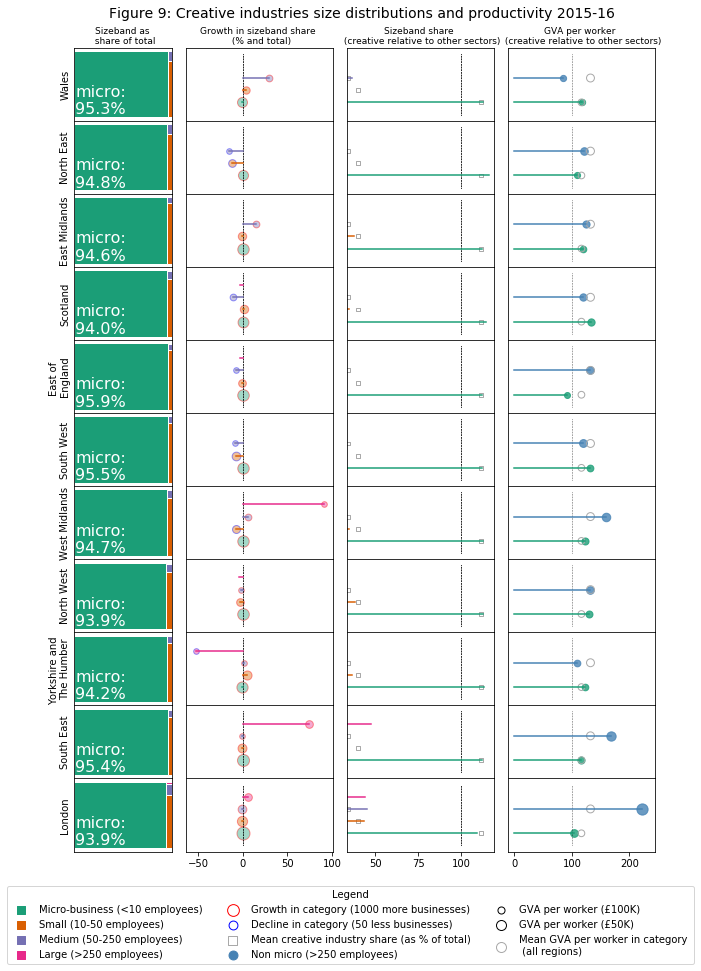

In [557]:
from matplotlib import patches

fig,ax = plt.subplots(figsize=(9,12),nrows=len(regions_sorted_no_ni),ncols=4,sharex='col',
                     gridspec_kw={'width_ratios':[2,3,3,3]}
                     )

#regions_sorted_no_ni = regions_sorted.remove('Northern Ireland')

for num,x in enumerate(reversed(regions_sorted_no_ni[::-1])):
    plot_sizebands(x,ax[num])
    
    #Remove titles and axes for all charts except the last one
    
ax[0][0].set_xlabel('Sizeband as \n share of total',size=9)
ax[0][1].set_xlabel('Growth in sizeband share \n (% and total)',size=9)
ax[0][2].set_xlabel('Sizeband share \n (creative relative to other sectors)',size=9)
ax[0][3].set_xlabel('GVA per worker \n (creative relative to other sectors)',size=9)


for x in np.arange(0,4):
    ax[0][x].xaxis.set_label_position('top')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0)


#Add custom legend with some invisible scatters
#Sizez
mic = plt.scatter([],[], s=80, marker='s',color=accent_colors[0])
sm = plt.scatter([],[], s=80, marker='s',color=accent_colors[1])
med = plt.scatter([],[], s=80, marker='s',color=accent_colors[2])
lar = plt.scatter([],[], s=80, marker='s',color=accent_colors[3])

#Growth and decline
size_gr = plt.scatter([],[], s=20*np.log(1000), marker='o',color='white',edgecolor='red') 
size_decl = plt.scatter([],[], s=20*np.log(50), marker='o',color='white',edgecolor='blue') 

#Size shares
avg_share = plt.scatter([],[],s=80, marker='s',facecolors='none',color='darkgrey')

#Productivities
non_micro = plt.scatter([],[],s=80, marker='o',color='steelblue')
gva_pw_1 = plt.scatter([],[],s=50, marker='o',color='black',facecolors='white')
gva_pw_2 = plt.scatter([],[],s=100, marker='o',color='black',facecolors='white')
avg_size = plt.scatter([],[],s=100, marker='o',color='darkgrey',facecolors='white')




empty = plt.scatter([],[],s=80, marker='o',color='white',edgecolor='white')


circles_h, circles_l = ax[len(regions_sorted_no_ni)-1][1].get_legend_handles_labels()

#ax[len(regions_sorted)-1][1].legend()


#ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
plt.legend((mic,sm,med,lar,
            size_gr,size_decl,avg_share,non_micro,gva_pw_1,gva_pw_2,avg_size),
           ('Micro-business (<10 employees)', 
            'Small (10-50 employees)', 
            'Medium (50-250 employees)',
            'Large (>250 employees)',
            'Growth in category (1000 more businesses)',
            'Decline in category (50 less businesses)',
            'Mean creative industry share (as % of total)',
            'Non micro (>250 employees)',
            'GVA per worker (£100K)',
            'GVA per worker (£50K)',
            'Mean GVA per worker in category \n (all regions)',),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(1.3,-0.4),ncol=3,fontsize=10)  



fig.suptitle('Figure 9: Creative industries size distributions and productivity 2015-16',y=1.01,fontsize=14)

plt.savefig(fig_path+'/{date}_figure_9_size_prod.pdf'.format(date=today_str),bbox_inches='tight')


#### Some stats for the report

In [558]:
size_pt = pd.pivot_table(idbr_sizebands_out.loc[idbr_sizebands_out.sector=='creative_industries'],
               index='sizeband',columns='year',values='value',aggfunc='sum')

size_pt = 100*size_pt.apply(lambda x: x/x.sum())
size_pt
#size_pt[2017]/size_pt[2016]

year,2016,2017
sizeband,,
Large (250+),0.088038,0.098200
Medium-sized (50 to 249),0.761795,0.752864
Micro (0 to 9),94.511121,94.581790
Small (10 to 49),4.639046,4.567146


#### Chart about impact on productivity of changes in company shares


We want to estimate the impact of creative industries growth on regional productivity under different scenarios

```
region | Total GVA | Creative GVA | Creative micro share | Creative micro GVA pw | Creative non m share |
    Creative non m GVA pw 

```

We will process it with a function to generate estimates of change in GVA and GVA per worker

In [559]:
gva_2

,employment,sizeband,gva_pw,sector,business_count,period,region,n,gva
0,2.249000e+04,micro,38.000000,Creative,11140.0,2013-15,North East,98.0,8.592900e+05
1,4.546600e+05,micro,35.000000,Other or unknown,175020.0,2013-15,North East,2122.0,1.571389e+07
2,2.973000e+04,non_micro,58.000000,Creative,745.0,2013-15,North East,54.0,1.730480e+06
3,1.510710e+06,non_micro,48.000000,Other or unknown,28750.0,2013-15,North East,2518.0,7.323607e+07
4,7.661000e+04,micro,49.000000,Creative,45020.0,2013-15,North West,398.0,3.738600e+06
5,1.076370e+06,micro,38.000000,Other or unknown,426400.0,2013-15,North West,5378.0,4.138910e+07
6,1.452900e+05,non_micro,58.000000,Creative,2815.0,2013-15,North West,210.0,8.435700e+06
7,5.449150e+06,non_micro,44.000000,Other or unknown,66040.0,2013-15,North West,6474.0,2.381852e+08
8,6.039000e+04,micro,44.000000,Creative,33695.0,2013-15,Yorkshire and the Humber,307.0,2.686090e+06
9,9.152200e+05,micro,36.000000,Other or unknown,358180.0,2013-15,Yorkshire and the Humber,4507.0,3.291381e+07


In [560]:
gva_2

,employment,sizeband,gva_pw,sector,business_count,period,region,n,gva
0,2.249000e+04,micro,38.000000,Creative,11140.0,2013-15,North East,98.0,8.592900e+05
1,4.546600e+05,micro,35.000000,Other or unknown,175020.0,2013-15,North East,2122.0,1.571389e+07
2,2.973000e+04,non_micro,58.000000,Creative,745.0,2013-15,North East,54.0,1.730480e+06
3,1.510710e+06,non_micro,48.000000,Other or unknown,28750.0,2013-15,North East,2518.0,7.323607e+07
4,7.661000e+04,micro,49.000000,Creative,45020.0,2013-15,North West,398.0,3.738600e+06
5,1.076370e+06,micro,38.000000,Other or unknown,426400.0,2013-15,North West,5378.0,4.138910e+07
6,1.452900e+05,non_micro,58.000000,Creative,2815.0,2013-15,North West,210.0,8.435700e+06
7,5.449150e+06,non_micro,44.000000,Other or unknown,66040.0,2013-15,North West,6474.0,2.381852e+08
8,6.039000e+04,micro,44.000000,Creative,33695.0,2013-15,Yorkshire and the Humber,307.0,2.686090e+06
9,9.152200e+05,micro,36.000000,Other or unknown,358180.0,2013-15,Yorkshire and the Humber,4507.0,3.291381e+07


In [561]:
#Create processed DF
gva_2 = gva.copy()

#Rename columns to make manipulation easier
gva_2.columns = ['employment','sizeband','gva_pw','sector','business_count','period','region','n','gva']
#['region','sizeband','gva','employment','business_count','gva_pw','sector','n','period']

#Change the sizes
gva_2.sizeband = ['micro' if '0-9'in x else 'non_micro' for x in gva_2.sizeband]

#Calculate region totals of employment and value added
region_totals= gva_2.groupby('region')['employment','gva'].sum().reset_index(drop=False)

#Calculate totals by sector
creative_region_totals= gva_2.groupby(['region','sector','sizeband'])['employment','gva','gva_pw'].sum().reset_index(
    drop=False)

#And subset by creative
creative_region_totals = creative_region_totals.loc[creative_region_totals.sector=='Creative',:]

#Pivot
creative_wide = pd.pivot_table(
    creative_region_totals,index='region',columns=['sizeband'],values=['gva','employment','gva_pw'])

#Change columns into a single index
creative_wide.columns = ['cr_'+x[0]+"_"+x[1] for x in creative_wide.columns]

creative_wide.reset_index(drop=False,inplace=True)

#Combine everything
prod_stats = pd.merge(region_totals,creative_wide,left_on='region',right_on='region')

#Shares
#Share of creative micro and non-micro employment
prod_stats['cr_employment_micro_share'],prod_stats[
    'cr_employment_non_micro_share'] = [prod_stats[x]/prod_stats['employment'] for x in ['cr_employment_micro',
                                                                                 'cr_employment_non_micro']]

#Share of creative micro and non micro GVA
prod_stats['cr_gva_micro_share'],prod_stats[
    'cr_gva_non_micro_share'] = [prod_stats[x]/prod_stats['gva'] for x in ['cr_gva_micro',
                                                                                 'cr_gva_non_micro']]

#GVA per worker total
prod_stats['gva_pw']=prod_stats['gva']/prod_stats['employment']

prod_stats.set_index('region',inplace=True)

In [572]:
gva_region_summs = gva_2.groupby(['sector','region'])[['gva','employment']].sum()
gva_region_summs['gva']/gva_region_summs['employment']

prod_stats

,employment,gva,cr_employment_micro,cr_employment_non_micro,cr_gva_micro,cr_gva_non_micro,cr_gva_pw_micro,cr_gva_pw_non_micro,cr_employment_micro_share,cr_employment_non_micro_share,cr_gva_micro_share,cr_gva_non_micro_share,gva_pw
region,,,,,,,,,,,,,
East Midlands,4.491380e+06,1.850530e+08,59950.000000,79520.00000,2.612720e+06,4.174360e+06,44.000000,52.000000,0.013348,0.017705,0.014119,0.022558,41.201824
East of England,2.154930e+06,9.187874e+07,42620.000000,57710.00000,1.515670e+06,3.336270e+06,36.000000,58.000000,0.019778,0.026780,0.016496,0.036312,42.636531
London,1.350331e+07,8.384491e+08,381600.000000,945780.00000,2.299671e+07,1.194094e+08,60.000000,126.000000,0.028260,0.070041,0.027428,0.142417,62.092114
North East,2.017590e+06,9.153973e+07,22490.000000,29730.00000,8.592900e+05,1.730480e+06,38.000000,58.000000,0.011147,0.014735,0.009387,0.018904,45.370829
North West,6.747420e+06,2.917486e+08,76610.000000,145290.00000,3.738600e+06,8.435700e+06,49.000000,58.000000,0.011354,0.021533,0.012814,0.028914,43.238534
Northern Ireland,1.078483e+06,3.940780e+07,12630.318042,33376.39257,4.063570e+05,1.257401e+06,64.346289,75.346732,0.011711,0.030948,0.010312,0.031907,36.540031
Scotland,4.569110e+06,2.014757e+08,60070.000000,83150.00000,3.165660e+06,4.502440e+06,53.000000,54.000000,0.013147,0.018198,0.015712,0.022347,44.095176
South East,1.455544e+07,7.500152e+08,319840.000000,494590.00000,1.628650e+07,4.304656e+07,51.000000,87.000000,0.021974,0.033980,0.021715,0.057394,51.528171
South West,4.797960e+06,2.306030e+08,93220.000000,108470.00000,4.266080e+06,6.704270e+06,46.000000,62.000000,0.019429,0.022608,0.018500,0.029073,48.062718


In [563]:
#We produce growth estimates using a function defined above, which scales employment and productivity by
#different factors

#Scenario 1:
#Employment expansion
only_micro_expansion = var_changes([1.1,1],'micro')
non_micro_expansion = var_changes([1.1,1],'non_micro')
all_expansion = only_micro_expansion+non_micro_expansion

#Scenario 2:
#Productivity expansion
only_micro_prod = var_changes([1,1.1],'micro')
non_micro_prod = var_changes([1,1.1],'non_micro')
all_prod = only_micro_prod+non_micro_prod

#Scenario 3:
#Joint expansion
only_micro_expansion_scale = var_changes([1.1,1.1],'micro')
non_micro_expansion_scale = var_changes([1.1,1.1],'non_micro')
all_expansion_prod = only_micro_expansion_scale+non_micro_expansion_scale

In [571]:
#Create the figure doing a list comprehension
#We extract growth statistics for different scenarios
figure_chart = pd.concat([
    extract_growth_stats(x,name) for x,name in zip([only_micro_expansion,non_micro_expansion,all_expansion,
                                                   only_micro_prod,non_micro_prod,all_prod,
                                                    only_micro_expansion_scale,non_micro_expansion_scale,
                                                    all_expansion_prod],
                                                   ['micro_expand','non_micro_expand','all_expand',
                                                   'micro_prod','non_micro_prod','all_prod',
                                                   'micro_expand_prod','non_micro_expand_prod',
                                                   'all_expand_prod'])],axis=1)

figure_chart

,micro_expand_gva_pw,micro_expand_gva_pw_rate,micro_expand_gva_up,micro_expand_gva_up_rate,non_micro_expand_gva_pw,non_micro_expand_gva_pw_rate,non_micro_expand_gva_up,non_micro_expand_gva_up_rate,all_expand_gva_pw,all_expand_gva_pw_rate,...,micro_expand_prod_gva_up,micro_expand_prod_gva_up_rate,non_micro_expand_prod_gva_pw,non_micro_expand_prod_gva_pw_rate,non_micro_expand_prod_gva_up,non_micro_expand_prod_gva_up_rate,all_expand_prod_gva_pw,all_expand_prod_gva_pw_rate,all_expand_prod_gva_up,all_expand_prod_gva_up_rate
region,,,,,,,,,,,,,,,,,,,,,
East Midlands,41.205554,1.000091,2.637800e+05,1.001425,41.220909,1.000463,4.135040e+05,1.002235,41.224607,1.000553,...,5.539380e+05,1.002993,41.322003,1.002917,8.683584e+05,1.004692,41.389969,1.004566,1.422296e+06,1.007686
East of England,42.623431,0.999693,1.534320e+05,1.001670,42.677565,1.000962,3.347180e+05,1.003643,42.664420,1.000654,...,3.222072e+05,1.003507,42.847968,1.004959,7.029078e+05,1.007650,42.912445,1.006471,1.025115e+06,1.011157
London,62.086219,0.999905,2.289600e+06,1.002731,62.536616,1.007159,1.191683e+07,1.014213,62.529517,1.007044,...,4.808160e+06,1.005735,63.500627,1.022684,2.502534e+07,1.029847,63.675529,1.025501,2.983350e+07,1.035582
North East,45.362621,0.999819,8.546200e+04,1.000934,45.389411,1.000410,1.724340e+05,1.001884,45.381195,1.000228,...,1.794702e+05,1.001961,45.483284,1.002479,3.621114e+05,1.003956,45.521438,1.003320,5.415816e+05,1.005916
North West,43.245068,1.000151,3.753890e+05,1.001287,43.270251,1.000734,8.426820e+05,1.002888,43.276735,1.000884,...,7.883169e+05,1.002702,43.407335,1.003904,1.769632e+06,1.006066,43.474661,1.005461,2.557949e+06,1.008768
Northern Ireland,36.572558,1.000890,8.127141e+04,1.002062,36.659758,1.003277,2.514802e+05,1.006381,36.692045,1.004160,...,1.706700e+05,1.004331,36.915464,1.010275,5.281084e+05,1.013401,37.029993,1.013409,6.987784e+05,1.017732
Scotland,44.106868,1.000265,3.183710e+05,1.001580,44.113168,1.000408,4.490100e+05,1.002229,44.124815,1.000672,...,6.685791e+05,1.003318,44.221070,1.002855,9.429210e+05,1.004680,44.308983,1.004849,1.611500e+06,1.007998
South East,51.527013,0.999978,1.631184e+06,1.002175,51.648295,1.002331,4.302933e+06,1.005737,51.646878,1.002304,...,3.425486e+06,1.004567,51.972380,1.008621,9.036159e+06,1.012048,52.092843,1.010959,1.246165e+07,1.016615
South West,48.058718,0.999917,4.288120e+05,1.001860,48.094156,1.000654,6.725140e+05,1.002916,48.090104,1.000570,...,9.005052e+05,1.003905,48.247992,1.003855,1.412279e+06,1.006124,48.341542,1.005801,2.312785e+06,1.010029


In [565]:
from itertools import product

In [566]:
#Create combinations of scenarios and metrics for plotting
scenarios = ['micro_expand','non_micro_expand','all_expand',
             'micro_prod','non_micro_prod','all_prod',
             'micro_expand_prod','non_micro_expand_prod','all_expand_prod']
metrics = ['gva_pw_rate','gva_up_rate']

prod_vars_to_chart = list(product(scenarios,metrics))

prod_vars_to_chart = [x[0]+'_'+x[1]  for x in prod_vars_to_chart]


def plot_estimates(place,ax):
    '''
    This function charts growth estimates for different regions
    
    '''
    place_data = figure_chart.loc[place,prod_vars_to_chart]


    for number in np.arange(len(scenarios)):
        
        if number>=6:
            x_ax= number+4
        else:
            if number>=3:
                x_ax=number+2
            else:
                x_ax=number
        
        set_color = 'green' if 'all' in scenarios[number] else 'orange' if 'non_micro' in scenarios[number] else 'blue'
        
        ax.bar(x_ax,height=100*place_data[scenarios[number]+'_gva_pw_rate']-100,color=set_color)
    
    ax.set_xlim((-1,len(scenarios)+4.5))
    ax.set_ylim(-0.1)
    
    
    ax.set_xticks([1,6,11])
    ax.set_xticklabels(['Extensive growth','Intensive growth','Intensive and extensive'],rotation=90)

    
    #ax.set_yscale('log')


In [567]:
#We sort regions by their maximum potential growth
regions_sorted_prod = figure_chart['all_expand_prod_gva_pw_rate'].sort_values(ascending=False).index

regions_sorted_prod

Index(['London', 'Northern Ireland', 'South East', 'East of England',
       'West Midlands', 'South West', 'North West', 'Scotland',
       'Yorkshire and the Humber', 'East Midlands', 'North East', 'Wales'],
      dtype='object', name='region')

In [568]:
1000*62.092114
1000*figure_chart.loc['London']['all_expand_prod_gva_pw']

63675.528921576108

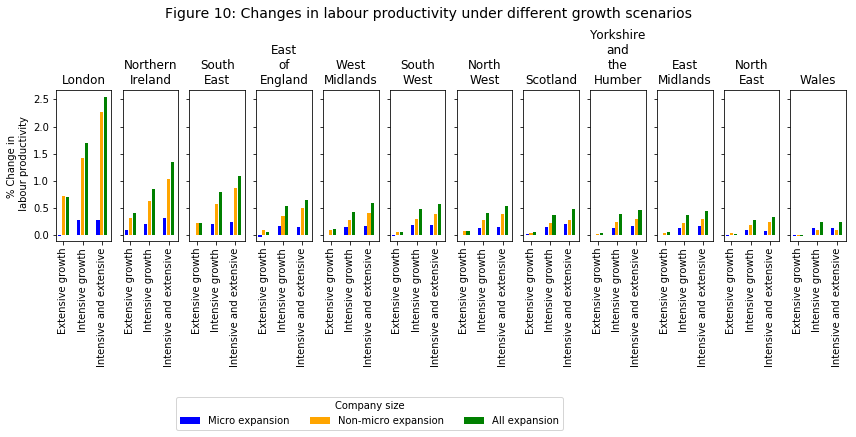

In [569]:
#Create plots
fig,ax = plt.subplots(figsize=(12,5),ncols=len(set(regions_sorted_prod)),
                      sharey=True
                     )
#For each region we use the function defined above
for num,place in enumerate(regions_sorted_prod):
    plot_estimates(place,ax[num])
    ax[num].set_title('\n'.join([x for x in place.split(" ")]))

    
#Labels and titles
fig.suptitle('Figure 10: Changes in labour productivity under different growth scenarios',y=1.03,fontsize=14)


ax[6].legend(['Micro expansion','Non-micro expansion','All expansion'],bbox_to_anchor=(2,-1),ncol=3,
            title='Company size')

ax[0].set_ylabel('% Change in \n labour productivity')

#Adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

#Save
plt.savefig(fig_path+'/{date}_figure_10_productivity_expansion.pdf'.format(date=today_str),bbox_inches='tight')

### Fact 4: Proximity and growth

#### Regional comparison

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


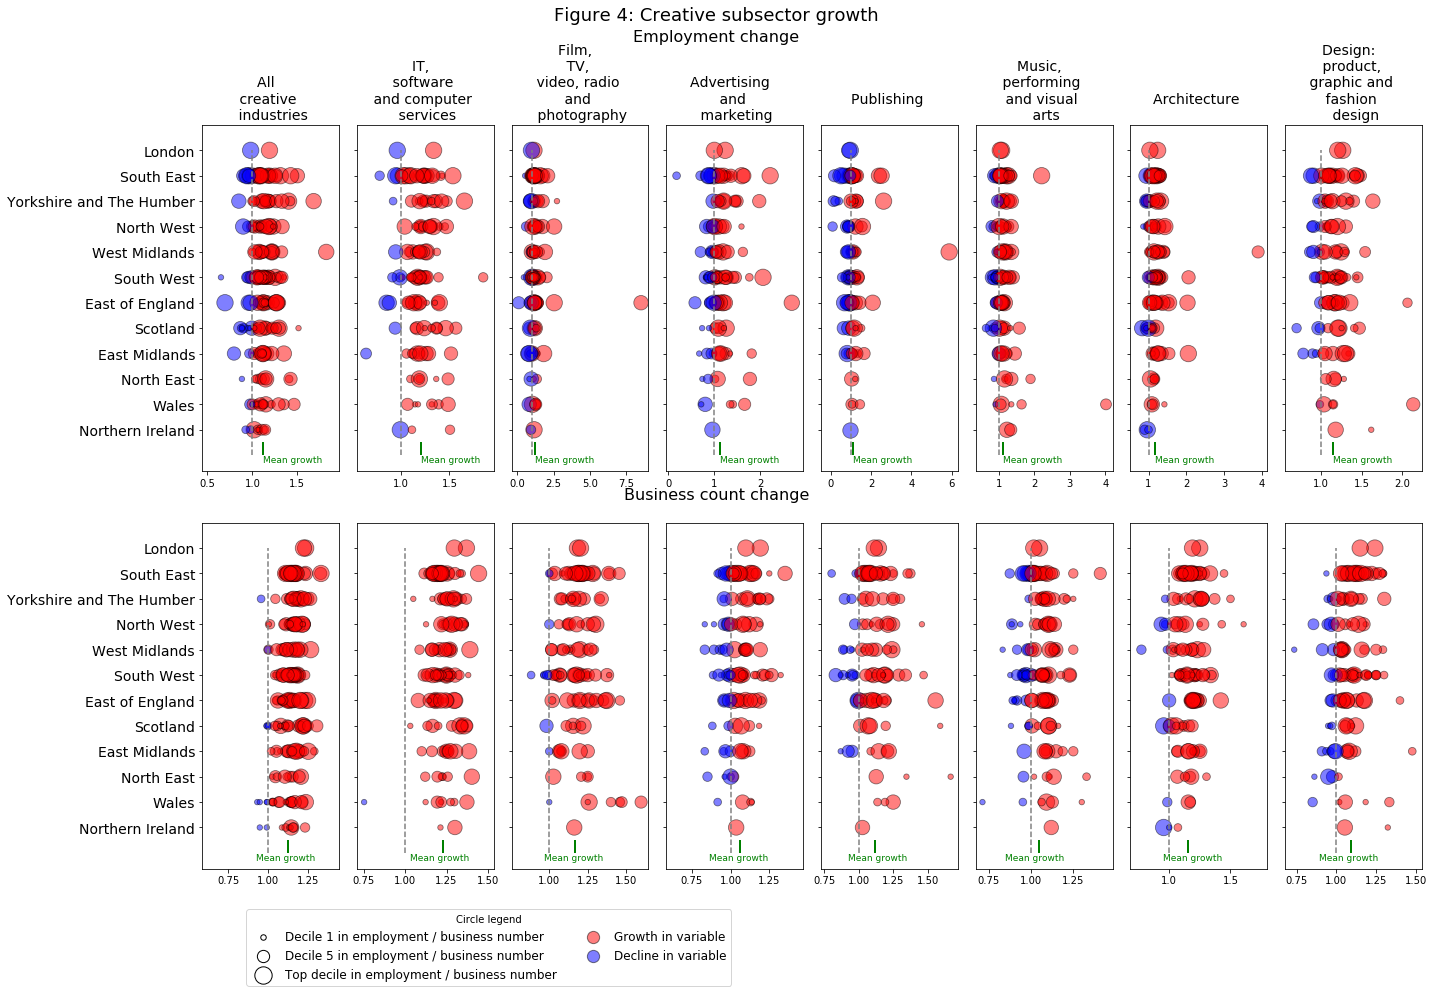

In [421]:
#We create a plot of TTWA growth by creative subsector and region

#Create plot
fig,ax = plt.subplots(ncols=len(sectors_sorted),nrows=2,figsize=(20,12),sharey='row',
                      #sharex='col'
                     )

regions_sorted = regions_sorted[::-1]

#Loop over sectors to subset
for num,x in enumerate(sectors_sorted):
    
    #Get data for the sector
    sector_data = all_changes.loc[all_changes.sector==x,:]
    
    #Convert the data into a collection of vectors for each region
    
    #1. Employment
    data_rate = [list(sector_data.loc[sector_data.region==reg,'employment_change'].dropna()) for reg in regions_sorted]
    data_total = [list(sector_data.loc[sector_data.region==reg,'emp_2015_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe (we use these for the circle sizes)
    sector_data['quantised']= pd.qcut(sector_data.loc[:,'emp_2015_2016'],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Now we produce the same vectors as before but with the quantiles
    data_quant = [list(sector_data.loc[sector_data.region==reg,'quantised'].dropna()) for reg in regions_sorted]
    
    #2. Business counts
    data_rate_bc = [list(sector_data.loc[sector_data.region==reg,'business_change'].dropna()) for reg in regions_sorted]
    data_total_bc = [list(sector_data.loc[sector_data.region==reg,'bc_2015_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe
    sector_data['quantised_bc']= pd.qcut(sector_data.loc[:,'bc_2015_2016'],
                                         q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Extract the deciles for each region
    data_quant_bc = [list(sector_data.loc[sector_data.region==reg,'quantised_bc'].dropna()) for reg in regions_sorted]
    
    #This loops over each region to subset its data and produce the scatter.
    for num_2,reg in enumerate(regions_sorted[::-1]):
        
        #This tells us how many points to use in the scatter (as many as there are TTWAs)
        tot = len(data_rate[num_2])
        
        #Draw the employment info in the top scatter
        ax[0][num].scatter(y=[num_2]*tot,
                        x=data_rate[num_2],
                        s=[x*30 for x in data_quant[num_2]],
                        alpha=0.5,
                        edgecolor='black',
                        linewidth=0.8,
                        c=['red' if x >1 else 'blue' for x in data_rate[num_2]])
        
        #Draw the business info inthe second scatter
        tot_2 = len(data_rate_bc[num_2])
        ax[1][num].scatter(y=[num_2]*tot_2,
                           x=data_rate_bc[num_2],
                           s=[x*30 for x in data_quant_bc[num_2]],
                           alpha=0.5,
                           edgecolor='black',
                           linewidth=0.8,
                           c=['red' if x >1 else 'blue' for x in data_rate_bc[num_2]])
    
    #We want to add chart titles that include a line break after a certain length
    sector_name = []
    
    split=x.split(" ")
    
    #If the number of words is above 3 it in
    split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    if '\n' not in split_rejoined:
        split_rejoined+=' \n'
    
    #Add all the titles and ticks
    ax[0][num].set_title(split_rejoined,size=14)
    ax[0][num].set_yticks(np.arange(len(regions_sorted)))
    ax[0][num].set_yticklabels(regions_sorted,size=14)
    
    #Add a vline to separate growth and decline
    ax[0][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Add a green line with mean growth for the sector
    ax[0][num].vlines(x=sector_data.loc[:,'employment_change'].dropna().mean(),
                     ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[0][num].annotate('Mean growth',xy=(sector_data.loc[:,'employment_change'].dropna().mean(),
                                          -1.3),color='green',size=9)
                       
    #Titles and ticks for the business count plots
    ax[1][num].set_yticks(np.arange(len(regions_sorted)))
    ax[1][num].set_yticklabels(regions_sorted,size=14)
    ax[1][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Mean growth for businesses 
    ax[1][num].vlines(x=sector_data.loc[:,'business_change'].dropna().mean(),
                      ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[1][num].annotate('Mean growth',xy=(sector_data.loc[:,'business_change'].dropna().mean()-0.2,
                                          -1.3),color='green',size=9)
    
    #Add custom legend with some invisible scatters
    d1 = plt.scatter([],[], s=30, marker='o',color='white',edgecolor='black')
    d5 = plt.scatter([],[], s=150, marker='o',color='white',edgecolor='black')
    d10 = plt.scatter([],[], s=300, marker='o',color='white',edgecolor='black')
    pg = plt.scatter([],[], s=150, marker='o',color='red',edgecolor='black',alpha=0.5)
    ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
    plt.legend((d1,d5,d10,pg,ng),
               ('Decile 1 in employment / business number', 
                'Decile 5 in employment / business number', 
                'Top decile in employment / business number',
               'Growth in variable','Decline in variable'),
               scatterpoints=1,
               title='Circle legend',
               bbox_to_anchor=(
                   -4,
                   -0.1),
               ncol=2,
               fontsize=12)    
    
#Add subplot row titles
plt.figtext(x=0.5,y=0.99,s='Employment change',size=16,ha='center')
plt.figtext(x=0.5,y=0.46,s='Business count change',size=16,ha='center')

#Layout
plt.tight_layout()

#Adjust subplots to create some space for the row titles
plt.subplots_adjust(hspace=0.15)

#Figure title
fig.suptitle('Figure 4: Creative subsector growth',y=1.03,size=18)

#Plot
plt.savefig(fig_path+'/{date}_figure_4_subsector_change.pdf'.format(date=today_str),bbox_inches='tight')

In [642]:
all_changes.loc[all_changes.sector=='Publishing',:].sort_values('employment_change').dropna().iloc[-1]

year
ttwa_name            Worcester and Kidderminster
sector                                Publishing
emp_2011_2014                              498.5
emp_2015_2016                               2925
employment_change                         5.8676
bc_2011_2014                                  40
bc_2015_2016                                42.5
business_change                           1.0625
emp_abs_change                            2426.5
bc_abs_change                                2.5
region                             West Midlands
is_cluster                                 False
ttwa_code                              E30000289
Name: 2005, dtype: object

In [644]:
all_changes.loc[['TV' in x for x in all_changes.sector],:].sort_values('employment_change').dropna().iloc[-1]

year
ttwa_name                                   Bury St Edmunds
sector               Film, TV, video, radio and photography
emp_2011_2014                                         51.75
emp_2015_2016                                           440
employment_change                                   8.50242
bc_2011_2014                                             29
bc_2015_2016                                           37.5
business_change                                      1.2931
emp_abs_change                                       388.25
bc_abs_change                                           8.5
region                                      East of England
is_cluster                                            False
ttwa_code                                         E30000184
Name: 364, dtype: object

#### Plot contingency tables

Here we will explore if there is a relationship between growth in an area and its neighbours' propensity to grow.
We will base this analysis in a simple comparison of proportions (a Chi squared test)



In [575]:
def get_neighbour_stats(df,sector,var):
    '''
    This function loops over each TTWA and estimates the mean scores of its neighbours in a variable (for a sector)
    It returns a dataframe with the means and a matrix combining their scores
    
    '''
    
    #Is it employment or bc?
    
    if var=='emp':
        var_1 = 'emp_lq_change'
        #var_1='employment_change'
        var_2 = 'emp_growth'
    else:
        var_1 = 'bc_lq_change'
        #var_1 = 'business_change'
        var_2 = 'bc_growth'
    
    
    #First step: subset by sector
    df_sector = df.loc[df.sector==sector,:]
    
    #Create a container
    cont = []
    mat = []
    #Second step: 
    #For each TTWA, subset by the neighbors and calculate averages.
    for x in df_sector['ttwa_name']:
        
        #Area's own score
        own_score = float(df_sector.loc[df_sector.ttwa_name==x,var_1])
        #print(own_score)
        
        #Extract neighbours
        try:
            neighs = neighbors_looked_up[x]
    
            #Subset variable to get neighbours
            neighbours = df_sector.loc[[x in neighs for x in df_sector['ttwa_name']],['ttwa_name',var_1]]
            
            #Calculate mean
            value = neighbours[var_1].dropna().mean()
            
            #Create new DF with all the neighbour info
            neighbours_2 = neighbours.set_index('ttwa_name')
            
            #Name the neighbours and transpose for concatenating on rows
            neighbours_2.columns=[x]
            neighbours_2 = neighbours_2.T
            
            #Create series
            out = pd.Series({'ttwa_name':x,'neighs':", ".join(neighs),'{n}_neighbor'.format(n=var):value,
                           '{n}_own'.format(n=var):own_score})
            
            mat.append(neighbours_2)

            
        except:
            out = pd.Series({'ttwa_name':x,'neighs':np.nan,'{n}_neighbor'.format(n=var):np.nan,
                           '{n}_own'.format(n=var):own_score})
        
        
        cont.append(out)


    
    #Out simple
    out_df = pd.DataFrame(cont).reset_index(drop=True)    
    
    #Add quantised data
    df_sector['{var}_growth_q'.format(var=var)] = pd.qcut(
        df_sector[var_2],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop') 
    
    
    #Out matrix
    out_mat = pd.concat(mat)
    
    return([pd.concat([out_df.set_index('ttwa_name'),
                       df_sector.set_index('ttwa_name')],axis=1)])

In [576]:
#Extract neighbour data
#Based on employment
neighbor_emp_data = {x:get_neighbour_stats(all_data.reset_index(drop=False),x,'emp')[0] for x in
                sectors_sorted}

#Based on business counts
neighbor_bc_data = {x:get_neighbour_stats(all_data.reset_index(drop=False),x,'bc')[0] for x in
                sectors_sorted}

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [577]:
def winsorise(vector,thres=99):
    '''
    Any value above the 0.99 percentile gets changed to the 0.99 percentile
    
    '''
    
    max_val = np.percentile(vector.dropna(),thres)
    
    min_val = np.percentile(vector.dropna(),100-thres)
    
    
    new_vector = [max_val if x > max_val else min_val if x <min_val else x for x in vector]
    #return([new_vector,max_val,min_val])
    
    return(new_vector)

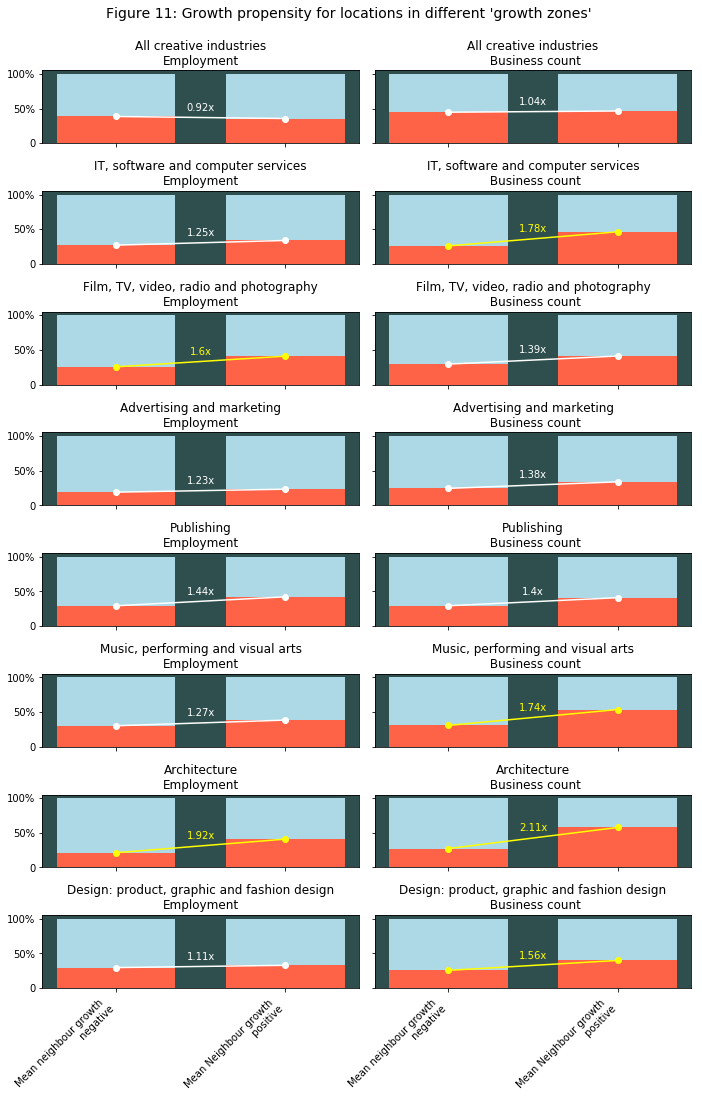

In [578]:
#Create barplot comparing proportions of growing TTWAs vs what happened with their neighbours
fig,ax = plt.subplots(nrows=len(sectors_sorted),ncols=2,figsize=(10,15),sharey=True,sharex=True)


#We do this for each sector
for num,x in enumerate(sectors_sorted):    

    #Extract employment stats for the sector
    emp_stats = neighbor_emp_data[x]
    bc_stats = neighbor_bc_data[x]
    
    
    #Produce contingency tables
    #Create employment contingency table. We sort the columns too.
    emp_cont = pd.crosstab(emp_stats['emp_own']>1,emp_stats['emp_neighbor']>1,normalize=1).iloc[[1,0],[0,1]]
    bc_cont = pd.crosstab(bc_stats['bc_own']>1,bc_stats['bc_neighbor']>1,normalize=1).iloc[[1,0],[0,1]]
    
    #Produce the chisq tests
    chi_sq_emp = chi2_contingency(pd.crosstab(emp_stats['emp_own']>1,emp_stats['emp_neighbor']>1))
    chi_sq_bc = chi2_contingency(pd.crosstab(bc_stats['bc_own']>1,bc_stats['bc_neighbor']>1))
    
    #print(chi_sq_bc)
    
    #Combinations of inputs to loop over
    contingency_list = [emp_cont,bc_cont]
    chi_list = [chi_sq_emp,chi_sq_bc]
    colors=['tomato','lightblue']
    
    #For each value
    for num_2 in [0,1]:
        #And now we loop over the columns of the table
        bot = [0,0]
        for val in [0,1]:
            ax[num][num_2].set_facecolor('darkslategrey')
            ax[num][num_2].bar(x=[0,1],height=contingency_list[num_2].iloc[val,:],bottom=bot,width=0.7,
                              color=colors[val])
            bot+=contingency_list[num_2].iloc[val,:]
            
            
        #Add line comparing proportions
        ax[num][num_2].plot([0,1],[contingency_list[num_2].iloc[0,0],
                            contingency_list[num_2].iloc[0,1]],
                            color='yellow' if chi_list[num_2][1]<0.05 else 'white',
                            marker='o')
        
        #Add number
        difference = str(np.round(contingency_list[num_2].iloc[0,1]/contingency_list[num_2].iloc[0,0],2))+'x'
        #print(difference)
        
        #Annotate
        ax[num][num_2].annotate(xy=(0.5,np.mean([contingency_list[num_2].iloc[0,0],
                                           contingency_list[num_2].iloc[0,1]])+0.1),s=difference,
                                horizontalalignment='center',
                               color='yellow' if chi_list[num_2][1]<0.05 else 'white')
        
        ax[num][num_2].set_title(x+'\n'+'Employment' if num_2==0 else x+'\n Business count')
    
    #Add labels
    ax[num][0].set_yticks([0,0.5,1])
    ax[num][0].set_yticklabels(['0','50%','100%'])
        
#Process the xlabels 
[ax[len(sectors_sorted)-1][number].set_xticks([0,1]) for number in [0,1]]

[ax[len(sectors_sorted)-1][number].set_xticklabels(['Mean neighbour growth \n negative',
                                                   'Mean Neighbour growth \n  positive'],
                                                  rotation=45,ha='right') for number in [0,1]]


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

fig.suptitle('Figure 11: Growth propensity for locations in different \'growth zones\'',fontsize=14,y=1.02)

plt.savefig(fig_path+'/{date}_figure_11_growth_comparison.pdf'.format(date=today_str),bbox_inches='tight')


### Fact 5. Survival rates and growth dynamics

**Actions**

* Descriptive analysis visualisation will require

``` 
Gdyn

TTWA \\ Type of change \\ Employment change (period 1) \\ Employment change (share of total)  \\ Employment change (period 1 vs period 2) \\ Surv rate

```




* Create a DF for EDA:

```
Micro-rate \\ Large firm share \\ Employment diversity \\ Business diversity \\ Survival rates \\ 
\\ Employment growth \\ Business growth \\ Specialisation growth \\ Diversification (#sectors with 
specialisation gains) \\ Number of sectors with business + employment specialisation gains
Growth dynamics (% of jobs created by large comps) \\ Churn \\ Company stability 

```

* Create heatmap and correlate
* Based on this, opt for charts to explore

** Some hypotheses to explore**

* More diverse / churny locations grow faster / have more employment growth due to hgfs
* More diverse locations gain specialisation in more sectors
* Locations with more microbusinesses are churnier
* Locations with more large firms are more stable



#### UK chart

In [181]:
#First: UK analysis
my_vars = ['Unnamed: 1','Number of firms','Change in employment']


growth_dfs = pd.concat([
    process_gdyn_data(df,name) for df,name in zip([gdyn_creat,gdyn_non_creat],['creative','non_creative'])],axis=0)

In [182]:
sorter = growth_dfs.reset_index(drop=False).groupby('Unnamed: 1')[
    'Number of firms'].sum().sort_values().index

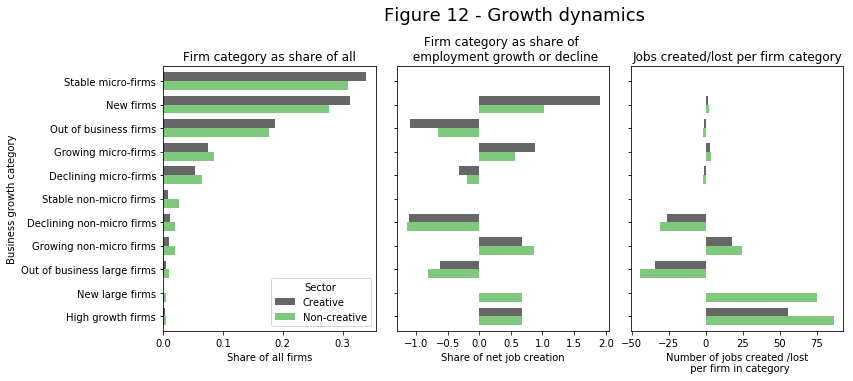

In [579]:
fig,ax = plt.subplots(ncols=3,figsize=(12,5),sharey=True)

growth_dfs = growth_dfs.loc[sorter]

titles=['Firm category as share of all','Firm category as share of \n employment growth or decline',
        'Jobs created/lost per firm category']

ylabs = ['Stable micro-firms','New firms','Out of business firms','Growing micro-firms',
         'Declining micro-firms','Stable non-micro firms','Declining non-micro firms','Growing non-micro firms',
        'Out of business large firms','New large firms','High growth firms']

xlabs = ['Share of all firms','Share of net job creation','Number of jobs created /lost\n  per firm in category']

for num,x in enumerate(['share_all_firms', 'share_all_employment','jobs_per_firm']):
    
    new_df = pd.pivot_table(growth_dfs.reset_index(drop=False),index='Unnamed: 1',
                                    columns='sector',values=x,aggfunc='sum').loc[sorter][['non_creative','creative']] 
    
    new_df.plot.barh(ax=ax[num],width=0.75,cmap='Accent') 
    
    if num>0:
        ax[num].legend().set_visible(False)
        
    else:
        handles, labels = ax[num].get_legend_handles_labels()
        ax[num].legend(labels=['Creative','Non-creative'],handles=handles[::-1],loc='lower right',title='Sector')
        
    ax[num].set_title(titles[num])
    ax[num].set_yticklabels(ylabs[::-1])
    ax[num].set_ylabel('Business growth category')
    
    ax[num].set_xlabel(xlabs[num])
    
    if num>2:
        ax[num].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

fig.suptitle("Figure 12 - Growth dynamics",y=1.05,x=0.6,size=18)

plt.savefig(fig_path+'/{today}_figure_12_growth_dyn.pdf'.format(today=today_str),bbox_inches='tight')



In [588]:
#Check growth stats
check_growth = growth_dfs.copy()
check_growth['share_all_employment_abs'] = np.abs(check_growth['share_all_employment'])

check_growth.loc[['death','birth']].groupby('sector')['share_all_employment_abs'].sum()

sector
creative        3.002784
non_creative    1.674197
Name: share_all_employment_abs, dtype: float64

In [607]:
#Create the 'high growth' chart
#Remove micro businesses form the data
growth_dfs_non_micro = growth_dfs.loc[['hgr','bigbirth','bigdeath','bv10logr','bv10dec','bv10sm']].reset_index(drop=False)


growth_dfs_non_micro['b_share_non_micro'] = growth_dfs_non_micro.groupby('sector')['Number of firms'].apply(lambda x: x/x.sum())
growth_dfs_non_micro['emp_share_non_micro'] = growth_dfs_non_micro.groupby('sector')['Change in employment'].apply(lambda x: np.abs(x/x.sum()))
growth_dfs_non_micro['jobs_per_comp'] = growth_dfs_non_micro['Change in employment']/growth_dfs_non_micro['Number of firms']

In [608]:
#growth_dfs_non_micro.groupby('sector')['Change in employment'].sum()
growth_dfs_non_micro.head()

,Unnamed: 1,Number of firms,Change in employment,share_all_firms,share_all_employment,jobs_per_firm,sector,b_share_non_micro,emp_share_non_micro,jobs_per_comp
0,hgr,1085,60470,0.0030575,0.673385,55.7327,creative,0.0846995,1.78536,55.7327
1,hgr,14440,1246400,0.00429133,0.671252,86.3158,non_creative,0.0503048,2.63365,86.3158
2,bigbirth,16830,1265780,0.0050016,0.681689,75.2097,non_creative,0.0586309,2.6746,75.2097
3,bigdeath,1605,-55310,0.00452285,-0.615924,-34.4611,creative,0.125293,1.63301,-34.4611
4,bigdeath,34100,-1508880,0.010134,-0.812611,-44.2487,non_creative,0.118795,3.18827,-44.2487


#### Selected TTWAs chart

In [212]:
# Clustering clusters

#We need to process the growth dynamics charts

#Label with TTWA
gdyn_ttwa['ttwa_name'] = [ttwa_name_lookup[x] if x in ttwa_name_lookup.keys() else np.nan for x in gdyn_ttwa.ttwa ]

#Select relevant vars

gdyn_sel = gdyn_ttwa[['ttwa_name','bandemployment','cohort','d_employment','entref','industry']]
gdyn_sel['dir'] = ['grow' if x in ['birth','bl10inc','bv10logr','hgr'] 
                   else 'stable' if x in ['bl10sm'] else 'decline' for x in gdyn_sel['bandemployment']]


#Calculate shares

#Share of businesses
gdyn_sel['biz_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry'])['entref'].apply(lambda x: x/x.sum())

gdyn_sel['emp_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry','dir'])[
    'd_employment'].apply(lambda x: np.abs(x)/x.sum())

gdyn_sel.head()


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,ttwa_name,bandemployment,cohort,d_employment,entref,industry,dir,biz_share,emp_share
0,Barnsley,birth,200709-201012,14940,4475,Other,grow,0.224536,0.470996
1,Barnsley,bl10dec,200709-201012,-2830,1660,Other,decline,0.083292,-0.069670
2,Barnsley,bl10inc,200709-201012,6730,2440,Other,grow,0.122428,0.212169
3,Barnsley,bl10sm,200709-201012,0,4965,Other,stable,0.249122,NaN
4,Barnsley,bv10dec,200709-201012,-19020,935,Other,decline,0.046914,-0.468242


In [214]:
#A bit more munging
#Focus only on the most recent cohort

gdyn_sel_recent = gdyn_sel.loc[(gdyn_sel.cohort=='201013-201316') & 
                               ([x in ['All creative','Other'] for x in gdyn_sel.industry]),:].drop('cohort',axis=1)

#Reshape to normalise creative vs other sectors
gdyn_comps = pd.pivot_table(gdyn_sel_recent,index=['ttwa_name','bandemployment'],
                            columns='industry',values=['emp_share','biz_share']).reset_index(drop=False)

#Change names of columns (multi-index)
gdyn_comps.columns = ["_".join(col) for col in gdyn_comps.columns]

#Create new column
gdyn_comps['creative_emp_vs_other'] = gdyn_comps['emp_share_All creative']/ gdyn_comps['emp_share_Other']

#Merge everything
gdyn_merged = pd.merge(gdyn_sel_recent.loc[gdyn_sel_recent.industry=='All creative'],
                       gdyn_comps,
                       left_on=['ttwa_name','bandemployment'],
                       right_on=['ttwa_name_','bandemployment_'])[
    ['ttwa_name','bandemployment','d_employment','entref','biz_share','emp_share','creative_emp_vs_other']]

gdyn_merged.head()

,ttwa_name,bandemployment,d_employment,entref,biz_share,emp_share,creative_emp_vs_other
0,Bradford,birth,4810,1590,0.334385,0.399170,0.854199
1,Bradford,bl10dec,-400,260,0.054679,-0.112360,2.502026
2,Bradford,bl10inc,1460,410,0.086225,0.121162,0.782912
3,Bradford,bl10sm,0,1435,0.301788,NaN,NaN
4,Bradford,bv10dec,-450,85,0.017876,-0.126404,0.227748


In [216]:
#Create a jobs creation var (also for sorting)

ttwa_emp_growth = gdyn_merged.groupby('ttwa_name')['d_employment'].sum().sort_values(ascending=False)

my_ttwas = [x for x in ttwa_emp_growth.index if x in ttwa_is_cluster + ['Birmingham']]
                                                                        #'Huddersfield']]


#Subset by its ttwa
gdyn_merged_cluster = gdyn_merged.loc[[x in ttwa_is_cluster+['Birmingham']
                                                             #'Huddersfield'] 
                                       for x in gdyn_merged.ttwa_name],:]

gdyn_merged_cluster.fillna(0,inplace=True)


#Some preps

#sort categories based on the levels of growth they create
bands_biz = gdyn_merged_cluster.groupby('bandemployment')['emp_share'].mean().sort_values(ascending=False)

#Color palette
bar_cols = plt.matplotlib.cm.get_cmap('Pastel2_r').colors[:8]

bands_biz_negs = list(bands_biz.index[bands_biz<0])
band_biz_pos = list(bands_biz.index[bands_biz>0])

surv_long = pd.melt(surv_ttwa,id_vars=['ttwa','industry'])
surv_long['ttwa_name'] = [ttwa_name_lookup[x] for x in surv_long.ttwa]

surv_sel = pd.pivot_table(surv_long.loc[[x in my_ttwas for x in surv_long.ttwa_name] and 
                        ['rate' in x for x in surv_long.variable],:],
                          index=['ttwa_name','variable'],columns='industry',values='value').reset_index(drop=False)

surv_sel.head()

/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


industry,ttwa_name,variable,Creative,Other or unknown
0,Aberdeen,surv_t_rate_1,0.907692,0.906357
1,Aberdeen,surv_t_rate_2,0.807692,0.813095
2,Aberdeen,surv_t_rate_3,0.707692,0.733156
3,Aberdeen,surv_t_rate_4,0.630769,0.658927
4,Aberdeen,surv_t_rate_5,0.569231,0.612105


In [193]:
#Collapse all these variables together

#Micro rate

#Group by creative sector
creative_sizebands = idbr_sizebands.loc[
    (idbr_sizebands.sector != 'not_in_sector') &(idbr_sizebands.year==2016),:].groupby(
    ['ttwa_name','sizeband'])['value'].sum().reset_index(drop=False)

#Extract sizeband share
creative_sizebands['sizeb_share'] = creative_sizebands.groupby('ttwa_name')['value'].apply(lambda x: x/x.sum())

#Pivot and extract large and micro
size_rates = pd.pivot_table(creative_sizebands,
                                        index='ttwa_name',
                                         columns='sizeband',values='sizeb_share',aggfunc='sum').reset_index(drop=False)

#Rename columns
size_rates.columns = ['ttwa_name','large_rate','medium_rate','micro_rate','small_rate']

#Ridiculously low levels of variation
size_rates['sme_rate'] = size_rates[['medium_rate','micro_rate','small_rate']].sum(axis=1)


In [201]:
creative_sectors = sectors_sorted.drop('All creative industries')

In [203]:
#Calculate employment herfindahl

#Calculate the employment herfindahl
emp_herf = pd.melt(empl_totals.loc[empl_totals.year=='2015_2016',['ttwa_name']+list(creative_sectors)],
                id_vars='ttwa_name').groupby('ttwa_name')['value'].apply(herfindahl).reset_index(drop=False)

emp_herf.columns = ['ttwa_name','emp_herf']

#Calculate the business count herfindahl
bc_herf = bc_totals_long.loc[bc_totals_long.year=='2015_2016',:].groupby('ttwa_name')['business_count'].apply(herfindahl).reset_index(drop=False)

bc_herf.columns = ['ttwa_name','bc_herf']


In [208]:
#Diversity
emp_div_2016 = pd.pivot_table(empl_lqs,
                         index='ttwa_name',columns='sector',values='emp_lq_2015_2016',aggfunc='sum')

#Employment diversity in 2016
emp_div = emp_div_2016.apply(add_positives,axis=1).reset_index(drop=False)
emp_div.columns=['ttwa_name','emp_div_2016']

#Employment diversity growth
emp_div_grow = pd.pivot_table(empl_lqs,
                         index='ttwa_name',columns='sector',values='emp_lq_change',aggfunc='sum')

#Employment diversity in 2016
emp_div_grow = emp_div_grow.apply(add_positives,axis=1).reset_index(drop=False)
emp_div_grow.columns=['ttwa_name','emp_esp_growth']


#Employment growth
emp_esp_growth = empl_lqs.loc[empl_lqs.sector=='All creative industries',:][
    ['ttwa_name','emp_lq_change']].reset_index(drop=True)

#Business diversity
business_div_2016 = pd.pivot_table(bc_lqs,
                                  index='ttwa_name',columns='sector',values='bc_lq_2015_2016',aggfunc='sum')

business_div = business_div_2016.apply(add_positives,axis=1).reset_index(drop=False)
business_div.columns = ['ttwa_name','bc_div_2016']

#Employment diversity growth
bus_div_grow = pd.pivot_table(bc_lqs,
                         index='ttwa_name',columns='sector',values='bc_lq_change',aggfunc='sum')

#Employment diversity in 2016
bus_div_grow = bus_div_grow.apply(add_positives,axis=1).reset_index(drop=False)
bus_div_grow.columns=['ttwa_name','bus_esp_growth']


#Business count growth
business_esp_growth = bc_lqs.loc[bc_lqs.sector=='All creative industries',:][
    ['ttwa_name','bc_lq_change']].reset_index(drop=True)


In [217]:
#Growth dynamism
business_shares = pd.pivot_table(gdyn_merged,index='ttwa_name',columns='bandemployment',
                            values=['biz_share','emp_share'])

business_shares.columns = [x[0]+x[1] for x in business_shares.columns]

business_shares['churn'] = business_shares[['biz_sharedeath','biz_sharebirth']].sum(axis=1)
business_shares.reset_index(drop=False,inplace=True)

#business_shares = business_shares.reset_index(drop=False)[['ttwa_name','churn','biz_sharehgr','emp_sharebl10inc']]

#Survival rates

surv_eda = surv_ttwa.loc[surv_ttwa.industry=='Creative',:]
surv_eda['ttwa_name'] = [ttwa_name_lookup[x] for x in surv_eda['ttwa']]

surv_eda_sel = surv_eda[['ttwa_name','surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Clustering

This involves a cluster analysis of growth dynamics: 

* Identify variables to cluster on
* Do PCA (and select number of components)
* Do cluster analysis and select cluster algorithm based on silouhette score after e.g. 1000 runs (grid search).
* Allocate companies to cluster after e.g. 1000 runs. How do we do this?


In [218]:
from itertools import product


In [219]:
#Combine all dfs into one big growth dynamics file
growth_eda_dfs = [size_rates,
                  emp_herf,bc_herf,
                  emp_div,emp_div_grow,business_div,
                  emp_esp_growth,business_esp_growth,
                  business_shares,
                  surv_eda_sel]
#Concatenated keeping all
growth_all = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='outer')


In [220]:
#Normalise all variables
growth_all_norm = growth_all.apply(normalise,axis=1)

#Produce correlation matrix
growth_corr = growth_all_norm.corr()

#All coordinates in the matrix 
prod = list(product(np.arange(0,len(growth_corr)),
               np.arange(0,len(growth_corr))))

for x in prod:
    if x[0]==x[1]:
        growth_corr.iloc[x[0],x[1]]=np.nan


In [221]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans,MeanShift
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

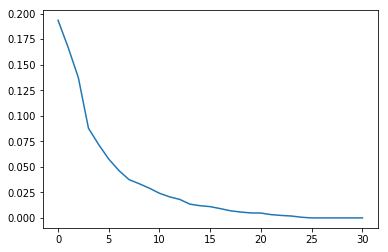

In [222]:
#Redo everything with cities

growth_city = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='inner')
growth_city_norm = growth_city.apply(normalise,axis=0).dropna(axis=0)

#Do the Principal Components analysis with all variables to select a cut-off point
pca_all = PCA()
#Fit
pca_all.fit(growth_city_norm)

#Explained variance to plot
explained_variance = pca_all.explained_variance_ratio_

plt.plot(explained_variance)

#plt.hlines(x = pca_all.explained_variance_ratio_>0.03.index[0])

In [223]:
explained_variance_thres =0.03
num_comps = [(num,x) for num, x in enumerate(explained_variance) if x>explained_variance_thres][-1][0]

#Extract and transform
pca = PCA(n_components=num_comps)
transformed = pca.fit_transform(growth_city_norm)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


[Text(0,0,'large_rate'),
 Text(0,0,'medium_rate'),
 Text(0,0,'micro_rate'),
 Text(0,0,'small_rate'),
 Text(0,0,'sme_rate'),
 Text(0,0,'emp_herf'),
 Text(0,0,'bc_herf'),
 Text(0,0,'emp_div_2016'),
 Text(0,0,'emp_esp_growth'),
 Text(0,0,'bc_div_2016'),
 Text(0,0,'emp_lq_change'),
 Text(0,0,'bc_lq_change'),
 Text(0,0,'biz_sharebirth'),
 Text(0,0,'biz_sharebl10dec'),
 Text(0,0,'biz_sharebl10inc'),
 Text(0,0,'biz_sharebl10sm'),
 Text(0,0,'biz_sharebv10dec'),
 Text(0,0,'biz_sharebv10logr'),
 Text(0,0,'biz_sharedeath'),
 Text(0,0,'biz_sharehgr'),
 Text(0,0,'emp_sharebirth'),
 Text(0,0,'emp_sharebl10dec'),
 Text(0,0,'emp_sharebl10inc'),
 Text(0,0,'emp_sharebv10dec'),
 Text(0,0,'emp_sharebv10logr'),
 Text(0,0,'emp_sharedeath'),
 Text(0,0,'emp_sharehgr'),
 Text(0,0,'churn'),
 Text(0,0,'surv_t_rate_1'),
 Text(0,0,'surv_t_rate_3'),
 Text(0,0,'surv_t_rate_6')]

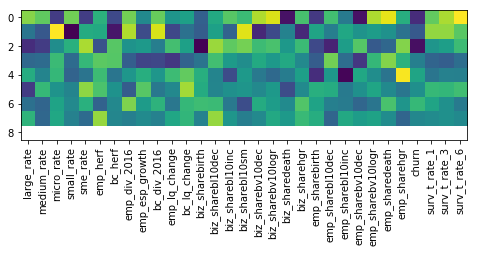

In [224]:
#Redo everything with cities

#Normalise city growth data
growth_city = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='inner')
growth_city_norm = growth_city.apply(normalise,axis=0).dropna(axis=0)

#Concatenate normalised scores and components
growth_city_norm_comps = pd.concat([growth_city_norm.reset_index(drop=False),pd.DataFrame(transformed,
                                         columns=np.arange(0,transformed.shape[1]))],axis=1)

#Extract the correlations
component_correlation = growth_city_norm_comps.corr()

fig,ax = plt.subplots(figsize=(8,15))

#Produce a heatmap of the correlation between each factor ands all the othewr variables
ax.imshow(component_correlation.loc[np.arange(0,9),[x not in np.arange(0,9) for x in component_correlation.columns]])

ax.set_xticks(np.arange(0,len(growth_city_norm.columns)))
ax.set_xticklabels(growth_city_norm.columns,rotation=90)

In [225]:
%%time
#Now we want to run the clustering

#Grid search problem. 

#We have a bunch of clustering algorithms and hyperparameters. We want to run those ~ 500 each and estimate
#the silouhette score (performance)

#Some of them have number of clusters to tune. Others don't
cluster_grid = [[KMeans,np.arange(3,10)],
                [AgglomerativeClustering, np.arange(3,10)],
                #[DBSCAN],
                [AffinityPropagation],
                [MeanShift],
                [SpectralClustering]]

#Scores container
score = []

#Loop
for x in cluster_grid:
    print(x)
    #If we need to tune the number of clusters:
    if len(x)>1:
        #For each of the cluster numbers
        for num in x[1]:
            sil_store= []
            for iteration in np.arange(0,200):
                #Predict the labels
                labs = x[0](n_clusters=num).fit_predict(transformed)
                
                #Generate the silouhette score
                sil = silhouette_score(transformed,labs)
                sil_store.append(sil)
            score.append([np.mean(sil_store),x[0],num])
    
    else:
    #If number of clusters isn't a hyperparameter
        sil_store = []
    
        for iteration in np.arange(0,200):
            #Predict the labels
            labs = x[0]().fit_predict(transformed)
                
            #Generate the silouhette score
            sil = silhouette_score(transformed,labs)
            sil_store.append(sil)
        
        score.append([np.mean(sil_store),x[0]])
            
            
            
        



[<class 'sklearn.cluster.k_means_.KMeans'>, array([3, 4, 5, 6, 7, 8, 9])]
[<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>, array([3, 4, 5, 6, 7, 8, 9])]
[<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>]
[<class 'sklearn.cluster.mean_shift_.MeanShift'>]
[<class 'sklearn.cluster.spectral.SpectralClustering'>]
CPU times: user 48.9 s, sys: 367 ms, total: 49.3 s
Wall time: 51.2 s


In [226]:
#Some of them have number of clusters to tune. Others don't
sorted(score,key=lambda x:x[0],reverse=True)

[[0.22327229537713272, sklearn.cluster.mean_shift_.MeanShift],
 [0.16248545942137319, sklearn.cluster.k_means_.KMeans, 8],
 [0.16087155014258778, sklearn.cluster.k_means_.KMeans, 7],
 [0.16078189723461872, sklearn.cluster.k_means_.KMeans, 9],
 [0.15960947688657406, sklearn.cluster.k_means_.KMeans, 6],
 [0.15749857827952699, sklearn.cluster.k_means_.KMeans, 5],
 [0.15602734693970535,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  7],
 [0.15102346179254167,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  9],
 [0.15002075516531588,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  4],
 [0.14987994399821142,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  3],
 [0.14958087104387227, sklearn.cluster.k_means_.KMeans, 4],
 [0.14939727910797992,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  8],
 [0.14437770979356745, sklearn.cluster.k_means_.KMeans, 3],
 [0.14137094250883453,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  6],
 [0.132

In [251]:
#Now we need a method to robustly allocate observations to clusters

#Idea:
#Run the clustering algorithm and identify pairs of observations
#Concatenate them. 
#Count how often are organisations paired together.


city_names = growth_city_norm.index

#These two lists store the results from the clustering
labels_store = []
combinations_store=[]

#Create a lookup of indices to city names
city_lookup = {num:y for num,y in enumerate(city_names)}

#This loops runs 5000 Kmeans clusters and stores the results in a list. We will use this list to create
#a network and identify its communities.

for x in np.arange(0,5000):
    #Run the clustering algorithm
    km = KMeans(n_clusters=6)
    
    labs = km.fit_predict(transformed)
    
    #This is a list of labels we append to the labs store container. We will use these data for consensus clustering
    labels_store.append(labs)
    
    labs_robustness = pd.Series(labs,index=city_names).sort_values()
    
    for y in set(labs_robustness):
        #Relevant cities
        cities = list(labs_robustness.index[labs_robustness==y])
        
        #combs = pd.DataFrame(list(combinations(cities,2)),columns=['c1','c2'])
        
        combinations_store.append(cities)
        
        
#all_matches = pd.concat(combinations_store)


In [252]:
#Put the cluster labels in a format we can work with
cluster_labels_consensus = np.array(pd.concat([pd.Series(x) for x in labels_store],axis=1))

In [253]:
import networkx as nx
import community

#Extract network from the combinations and detect communities inside it.
net = extract_network_from_corpus(combinations_store)
allocation = community.best_partition(net,resolution=0.6)

comm_out = pd.DataFrame({'ttwa_name':[x for x in allocation.keys()], 
              'cluster':[x for x in allocation.values()]}).set_index('ttwa_name').loc[my_ttwas].sort_values('cluster')


ttwas_clustering_ordered = comm_out.dropna().index

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [258]:
#Plot differences between clusters
labelled_df = pd.concat(
    [growth_city_norm,comm_out],axis=1).loc[[x for x in my_ttwas if x!='Belfast']]

#labelled_df.sort_values('cluster').reset_index(drop=False)[['cluster','index']]

[Text(0,0,'0.0'),
 Text(0,0,'1.0'),
 Text(0,0,'2.0'),
 Text(0,0,'3.0'),
 Text(0,0,'4.0')]

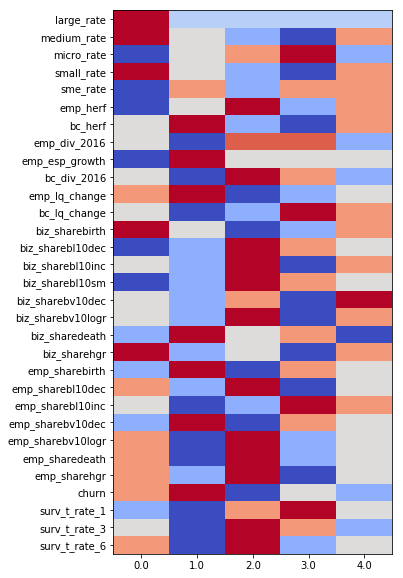

In [260]:
#Plot differences between clusters
labelled_df = pd.concat(
    [growth_city_norm,comm_out],axis=1).loc[my_ttwas]

labelled_df.rename(columns={0:'cluster'},inplace=True)

fig,ax = plt.subplots(figsize=(5,10))

meds = labelled_df.groupby('cluster').median().rank()


ax.imshow(meds.T,aspect='auto',cmap='coolwarm')

ax.set_yticks(np.arange(0,len(meds.T.index)))
ax.set_yticklabels(meds.T.index)

ax.set_xticks(np.arange(0,len(meds.index)))
ax.set_xticklabels(set(meds.index))

In [261]:
#What are the distances between clusters? We want to use that to arrange the rows and columns in the heatmap

means = labelled_df.groupby('cluster').mean()

cluster_distances = means.T.corr().sort_values(1,ascending=False).index

#cluster_distances

In [262]:
#Here we 

clusters_and_labels = labelled_df['cluster'].dropna()


#clusters_and_labels
ttwas_clustering_ordered= [(city,num) for el,num in zip([clusters_and_labels.index[
    clusters_and_labels==x] for x in cluster_distances],cluster_distances) for city in el] 

ttwas_clust_ord_unl = [x[0] for x in ttwas_clustering_ordered]


#Dataframe
ttwas_clustering_ordered_df = pd.DataFrame({'cluster_index':[x[1] for x in ttwas_clustering_ordered]},
                                           index=[x[0] for x in ttwas_clustering_ordered])

In [263]:
#Set-up for the chart

#The -1 removes Belfast (for which we have no data)
#ordered = labelled_df['cluster'].sort_values()

#Give the correlation matrix some indices
#Correlation between city profiles
city_corr = pd.DataFrame(transformed).T.corr()

city_corr.index=growth_city_norm.index
city_corr.columns=growth_city_norm.index

#Focus on our clusters
city_corr = city_corr.loc[[x in my_ttwas for x in city_corr.index],
                                  [x in my_ttwas for x in city_corr.columns]]

#Color palette and color type lookup
cluster_type_colors = plt.cm.get_cmap('Set1').colors[:5]

cluster_type_col_lookup = {num:cluster_type_colors[num] for num in np.arange(0,5)}

#Also create a city - color lookup.
ttwa_color_lu = {x[0]:cluster_type_col_lookup[int(x[1])] for x in ttwas_clustering_ordered}

#Remove some irrelevant stuff
selected_vars = [x for x in growth_city_norm.columns if x not in ['sme_rate','small_rate','emp_esp_growth']]


#Reorder index
selected_vars_index = [0,1,2,3,5,4,6,7,8,9,11,14,16,12,10,13,15,17,19,21,23,18,20,22,24,25,26,27]

clean_growth_dyn_names = ['Large firms (%)','Medium firms (%)','Micro firms (%)',
                          
                          'Sector specialisation (jobs)','Sector diversity (jobs)',
                          'Sector specialisation (businesses)','Sector diversity (businesses)',
                          'Clustering growth (jobs)',
                          'Clustering growth (businesses)',
                          
                          'New firms (% firms)','Micro growth (% firms)','Non-micro growth (% firms)',
                          'High growth (% firms)','Micro stable (% firms)',

                          "Micro decline (% firms)","Non-micro decline (% firms)","Out of business (% firms)",
                          
                          'New firms (% new jobs)','Micro growth (% new jobs)','Non-micro growth (% new jobs)',
                          'High growth (% new jobs)',
                          'Non-micro decline (% lost jobs)','Micro decline (% lost jobs)',
                          'Out of businesses (% lost jobs)',
                          
                          'Churn','Surv. rate (1 year)','Surv. rate (3 years)','Surv. rate (6 years)']

#growth_city_norm.columns
selected_vars_ordered = [selected_vars[x] for x in selected_vars_index]

long_name_short_name_lookup = {x:y for x,y in zip(selected_vars_ordered,clean_growth_dyn_names)}

cluster_categories = ['Cluster type 1','Cluster type 2','Cluster type 3','Cluster type 4','Cluster type 5']


In [627]:
cluster_model_labels = {x:y for x,y in zip([1,3,0,4,2],
                                     ('Incipient clusters','Creative districts','Creative cities',
                                      'Creative challengers','Creative conurbations'))}

cluster_model_labels

{0: 'Creative cities',
 1: 'Incipient clusters',
 2: 'Creative conurbations',
 3: 'Creative districts',
 4: 'Creative challengers'}

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:109: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


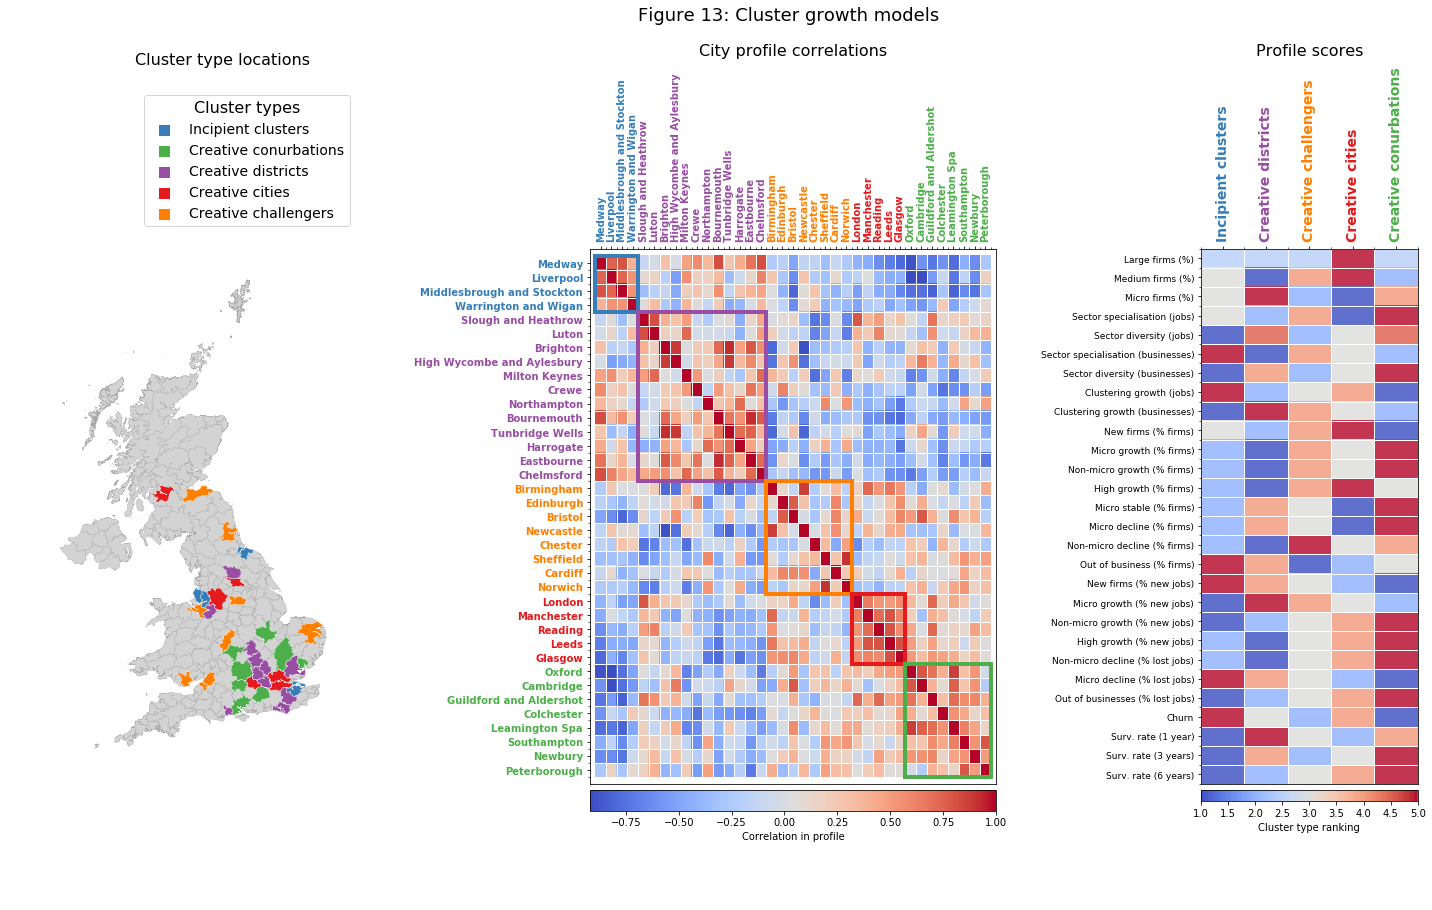

In [630]:
#Plot the map of the UK

#Axes
fig,(ax_1,ax_2,ax_3) = plt.subplots(figsize=(20,12),
                                                   ncols=3,
                                                   #Lay down a grid
                                                   gridspec_kw={'width_ratios':[1.2,1.5,0.8]})

#1st a Map
#Create the geodataframe with the data
cluster_types = pd.merge(ttwa_shp_read,ttwas_clustering_ordered_df.reset_index(drop=False),left_on='TTWA11NM',
                         right_on='index',how='outer')

#Plot the basemap
cluster_types.plot(color='lightgrey',ax=ax_1,edgecolors='darkgrey',linewidth=0.3)

#Plot the TTWAs using the color lookup
for x in np.arange(0,5):
    cluster_set = cluster_types.loc[cluster_types.cluster_index==x,:]
    
    cluster_set.plot(color=cluster_type_col_lookup[x],ax=ax_1,edgecolors='white',linewidth=0.3,legend=True)
    

#Arrange axes (we partly need to do this to deal with some misalignement between axes created by the 
#colorbars in the heatmaps. It is quite a hacky solution which I shoudl fix.

#Axes
ax_1.set_xlim(0,800000)
ax_1.set_ylim(-350000,1300000)
ax_1.set_axis_off()

#Title
ax_1.set_title('Cluster type locations',y=1.28,size=16)


#Create a heatmap of similarities between locations
a2 = ax_2.imshow(city_corr.loc[ttwas_clust_ord_unl,
                             ttwas_clust_ord_unl],
               #cmap=this_cmap,
               cmap='coolwarm',
               aspect='auto')

#Creaye the xticks and labels
ax_2.set_xticks(np.arange(0,len(ttwas_clust_ord_unl)))
ax_2.set_xticklabels(ttwas_clust_ord_unl,rotation=90)
ax_2.xaxis.tick_top()

ax_2.set_yticklabels(ttwas_clust_ord_unl)
ax_2.set_yticks(np.arange(0,len(ttwas_clustering_ordered)))


ax_2.set_xlim(-1,len(city_corr))
ax_2.set_ylim(len(city_corr),-1)

#Add a grid to the set.
ax_2.set_yticks(np.arange(0.5,len(city_corr)+0.5),minor=True)
ax_2.set_xticks(np.arange(0.5,len(city_corr)+0.5),minor=True)
ax_2.grid(which='minor',color='white',linestyle='-',linewidth=1)


#Change colors of axes tick labels using the cluster lookup
#First the x axis
[tick_label.set_color(ttwa_color_lu[name]) for name,tick_label in zip(ttwas_clust_ord_unl,ax_2.get_xticklabels())]
ax_2.set_xticklabels(ax_2.get_xticklabels(),{'weight':'bold'})

#Then the y axis
[tick_label.set_color(ttwa_color_lu[name]) for name, tick_label in zip(ttwas_clust_ord_unl,
                                                                      ax_2.get_yticklabels())]
ax_2.set_yticklabels(ax_2.get_xticklabels(),{'weight':'bold'})

#Highlight the clusters
#This is the order of cities in the DF
orders = ttwas_clustering_ordered_df.reset_index(drop=True)

#The function below uses the index to extract the coordinates of the square
ser = []

#For each cluster type, find the max and min of its index
for x in cluster_distances:
    var = orders[orders==x].dropna().index
    ser.append([min(var),max(var)])

#This was challenging!
for coord,clust_num in zip(ser,cluster_distances):
    
    clust_color = cluster_type_col_lookup[clust_num]
    
    ax_2.plot([coord[0]-0.5,coord[0]-0.5],[coord[0]-0.5,coord[1]+0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    ax_2.plot([coord[0]-0.5,coord[1]+0.5],[coord[1]+0.5,coord[1]+0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    
    ax_2.plot([coord[1]+0.5,coord[1]+0.5],[coord[1]+0.5,coord[0]-0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
 
    ax_2.plot([coord[0]-0.5,coord[1]+0.5],[coord[0]-0.5,coord[0]-0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    
#Title of that axis
ax_2.set_title('City profile correlations',y=1.35,size=16)

#3rd plot
#Plot differences between clusters
labelled_df = pd.concat(
    [growth_city_norm,comm_out],axis=1).loc[my_ttwas]

labelled_df.rename(columns={0:'cluster'},inplace=True)


#Calculate medians and rank them
meds = labelled_df.groupby('cluster').median().rank()[selected_vars_ordered]

#Draw
a3 = ax_3.imshow(meds.T[cluster_distances],aspect='auto',cmap='coolwarm',alpha=0.8)

#Create x tick labels and color
ax_3.set_xticks(np.arange(0,5))
ax_3.set_xticklabels([cluster_model_labels[x] for x in cluster_distances],rotation=90,size=14)

ax_3.xaxis.tick_top()

#Change colors
[tick_label.set_color(cluster_type_col_lookup [int(x)]) for x,tick_label in zip(
    list(cluster_distances),ax_3.get_xticklabels())]

ax_3.set_xticklabels(ax_3.get_xticklabels(),{'weight':'bold'})

#Yticks
ax_3.set_yticks(np.arange(0,len(meds.T.index)))
ax_3.set_yticklabels([long_name_short_name_lookup[x] for x in meds.T.index],size=9)

#Grid
ax_3.set_yticks(np.arange(-0.5,len(meds.T.index)),minor=True)
ax_3.set_xticks(np.arange(-0.5,5.5),minor=True)
ax_3.grid(which='minor',color='white',linestyle='-',linewidth=1)

#Add title
ax_3.set_title('Profile scores',y=1.35,size=16)

#Add layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

#Custom plots
cl1 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[1])
cl2 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[2])
cl3 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[3])
cl4 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[0])
cl5 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[4])

#Add legend
legend = plt.legend((cl1,cl2,cl3,cl4,cl5),
           ('Incipient clusters','Creative conurbations','Creative districts','Creative cities','Creative challengers'),
           scatterpoints=1,
           title='Cluster types',
           bbox_to_anchor=(-3.9,1.3),ncol=1,fontsize=14)

legend.get_title().set_fontsize('16')

#Add colorbars
fig.colorbar(a2, ax=ax_2,orientation='horizontal',pad=0.01,label='Correlation in profile')

fig.colorbar(a3, ax=ax_3,orientation='horizontal',pad=0.01,label='Cluster type ranking')

plt.tight_layout()

fig.suptitle('Figure 13: Cluster growth models',size=18,y=1.05,x=0.55)

plt.savefig(fig_path+'/{date}_figure_13_cluster_models.pdf'.format(date=today_str),bbox_inches='tight')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0


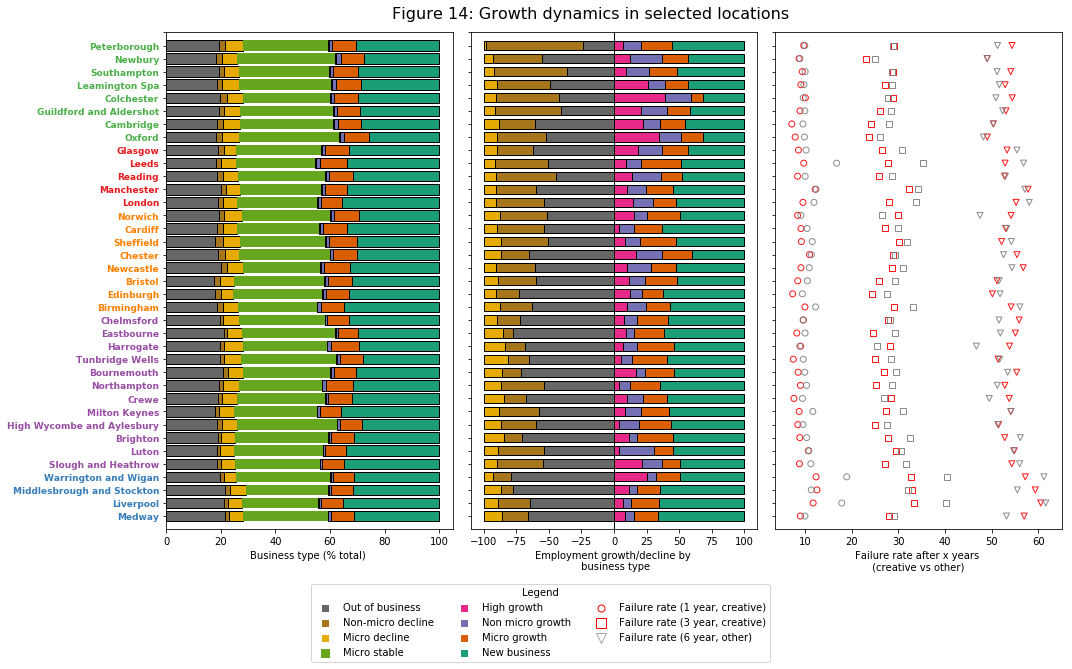

In [645]:
#Draw plot

bar_cols = plt.matplotlib.cm.get_cmap('Dark2_r').colors[:8]

fig,ax = plt.subplots(figsize=(15,8),ncols=3,sharey=True)

#Loop over TTWAs
for num,ttwa in enumerate(ttwas_clust_ord_unl):
    
    #Subset
    ttwa_data = gdyn_merged_cluster.loc[gdyn_merged_cluster.ttwa_name==ttwa,:]
    
    #Bottom for bars
    bot_biz = 0
    bottom_decl=0
    bottom_gr=0
    
    for num_2,sizeb in enumerate(reversed(bands_biz.index)):
        
        #Business growth share
        value_biz=100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'biz_share'])
        #print(value)
        ax[0].barh(bottom=num,width=value_biz,height=0.8,left=bot_biz,
               color=bar_cols[num_2],
               edgecolor='black' if sizeb in band_biz_pos else 'black' if sizeb in bands_biz_negs else None)
        
        bot_biz = bot_biz+value_biz
        
        #Employment value
        value_emp = 100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'emp_share'])
        
        #Plot upwards if the sizeband is positive, downwards if the sizeband is negative
        if sizeb in list(bands_biz_negs):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_decl,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_decl = bottom_decl + value_emp
            
        if sizeb in list(band_biz_pos):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_gr,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_gr = bottom_gr + value_emp
        
        #Draw horizontal line
        ax[1].vlines(x=0,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        
        
        #Survivals
    surv_in_ttwa = surv_sel.loc[surv_sel.ttwa_name==ttwa,:]
        
    for y in ['surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']:
        surv_cr= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Creative'])
        surv_other= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Other or unknown'])
        
            #print(surv_cr)
        
        if '1' in y:
            my_marker = 'o'
            
        if '3' in y:
            my_marker = 's'
            
        if '6' in y:
            my_marker = 'v'
        
        
        ax[2].scatter(y=num,x=surv_cr,marker=my_marker,color='red',alpha=0.9,facecolors='none')
        ax[2].scatter(y=num,x=surv_other,marker=my_marker,color='grey',alpha=0.9,facecolors='none')
        
    ax[0].set_yticks(np.arange(0,len(my_ttwas)))
    ax[0].set_yticklabels(ttwas_clust_ord_unl,
                          #rotation=90,
                              #ha='right'
                          size=9)


#Label titles
ax[0].set_xlabel('Business type (% total) \n')
ax[1].set_xlabel('Employment growth/decline by \n business type')
#ax[2].set_xlabel('Business type \n (creative vs other)')
ax[2].set_xlabel('Failure rate after x years \n (creative vs other) \n')
    

#Some final customisation
[ax[num].set_ylim(-1,len(ttwas_clust_ord_unl)) for num in [0,1,2]]        

#Customise labels
[tick.set_color(cluster_type_col_lookup[c_type]) for c_type,tick in zip([x[1] for x in ttwas_clustering_ordered],
                                                                            ax[0].yaxis.get_ticklabels())]

#Set xticklabels bold (to make them easier to read)
ax[0].set_yticklabels(ax[0].get_yticklabels(),{'weight':'bold'})

#Legends
#Add custom legend with some invisible scatters
#Performance

death = plt.scatter([],[], s=80, marker='s',color=bar_cols[0],edgecolor='white')
bv10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[1],edgecolor='white')
bl10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[2],edgecolor='white')
bl10sm = plt.scatter([],[], s=80, marker='s',color=bar_cols[3])
hgr = plt.scatter([],[], s=80, marker='s',color=bar_cols[4],edgecolor='white')
bv10logr = plt.scatter([],[], s=80, marker='s',color=bar_cols[5],edgecolor='white')
bl10inc = plt.scatter([],[], s=80, marker='s',color=bar_cols[6],edgecolor='white')
birth = plt.scatter([],[], s=80, marker='s',color=bar_cols[7],edgecolor='white')

#Survival
surv_1 = plt.scatter([],[],s=50, marker='o',color='red',facecolors='white')
surv_3 = plt.scatter([],[],s=100, marker='s',color='red',facecolors='white')
surv_5 = plt.scatter([],[],s=100, marker='v',color='darkgrey',facecolors='white')


#Add legend
plt.legend((death, bv10dec, bl10dec, bl10sm, hgr, bv10logr, bl10inc, birth,surv_1,surv_3,surv_5),
           ('Out of business','Non-micro decline','Micro decline','Micro stable','High growth','Non micro growth',
           'Micro growth','New business','Failure rate (1 year, creative)',
            'Failure rate (3 year, creative)','Failure rate (6 year, other)'),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(0,-0.1),ncol=3,fontsize=10)  

plt.subplots_adjust(wspace=0.04)

plt.tight_layout()

fig.suptitle('Figure 14: Growth dynamics in selected locations',y=1.02,x=0.55,size=16)

plt.savefig(fig_path+'/{date}_figure_14_growth_dynamics_hor.pdf'.format(date=today_str),bbox_inches='tight')

In [610]:
cluster_categories

['Cluster type 1',
 'Cluster type 2',
 'Cluster type 3',
 'Cluster type 4',
 'Cluster type 5']

In [272]:
off_stats = all_changes

#Add TTWA codes
off_stats['ttwa_code'] = [ttwa_names_to_codes_lookup[x] if x in ttwa_names_to_codes_lookup.keys() else np.nan for x in off_stats['ttwa_name']]
off_stats['is_cluster'] = [x in my_ttwas for x in off_stats.ttwa_name]


all_changes.to_csv(ext_data+'/{today}_processed_data.csv'.format(today=today_str))

## Outputs for Roxana

In [287]:
def add_metadata(df):
    '''
    Adds regions, ttwa code and whether an organisation is a cluster to a df
    '''
    
    if 'ttwa_name' not in df.columns:
        df.reset_index(drop=False,inplace=True)
    
    if 'ttwa_code' not in df.columns:
        df['ttwa_code']= [ttwa_names_to_codes_lookup[x] if x !='Taunton' else np.nan for x in df.ttwa_name]
    
    df['region'] = [ttwa_region_lookup[x] for x in df.ttwa_name]
    
    df['is_cluster'] = [x in my_ttwas for x in df.ttwa_name]
    
    return(df.dropna(axis=0,subset=['ttwa_code']))
    
    
    

In [290]:
rox_path = top+'/data/roxana/'

#Employment totals
add_metadata(empl_totals).to_csv(rox_path+'{date}_employment_totals.csv'.format(date=today_str),index=False)

#Employment changes
empl_changes_wide = pd.pivot_table(empl_changes,index='ttwa_name',columns='sector',values='employment_change')-1
add_metadata(empl_changes_wide).to_csv(rox_path+'{date}_employment_changes.csv'.format(date=today_str),index=False)


#Business totals
add_metadata(bc_totals).to_csv(rox_path+'{date}_business_totals.csv'.format(date=today_str),index=False)

#IDBR changes
bc_changes_wide = pd.pivot_table(bc_changes,index='ttwa_name',columns='sector',values='business_change')-1

add_metadata(bc_changes_wide).to_csv(rox_path+'{date}_business_change.csv'.format(date=today_str),index=False)

#IDBR sizebands


In [291]:
#Sizebands
idbr_sizebands_out = idbr_sizebands.copy()

idbr_sizebands_out['sector_size'] = [y+'_'+x for x,y in zip(idbr_sizebands_out['sector'],
                                                           idbr_sizebands_out['sizeband'])]

idbr_sizebands_out_wide = pd.pivot_table(idbr_sizebands_out,index=['ttwa_name','year'],columns='sector_size',
                                        values='value')

#Out
add_metadata(idbr_sizebands_out_wide).to_csv(rox_path+'{date}_business_sizebands.csv'.format(date=today_str),index=False)

In [292]:
#Growth dynamics

gdyn_rox = gdyn_sel.loc[(gdyn_sel.cohort=='201013-201316') &
                        (gdyn_sel.industry=='All creative'),['ttwa_name','bandemployment',
                                                            'd_employment','entref','biz_share','emp_share']]


gdyn_rox.rename(columns={'bandemployment':'company type',
                         'd_employment':'employment_change',
                        'entref':'n_company',
                         'biz_share':'share_all_business',
                         'emp_share':'share_all_employment_change'},inplace=True)

add_metadata(gdyn_rox.dropna()).to_csv(rox_path+'{date}_growth_dynamics.csv'.format(date=today_str),index=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [293]:
#Survival
surv_eda_rox = surv_eda_sel.copy()

surv_eda_rox.columns = ['ttwa_name','survival_rate_1_year','survival_rate_3_year','survival_rate_6_year']


add_metadata(surv_eda_rox).to_csv(rox_path+'{date}_survival_rates.csv'.format(date=today_str),index=False)

In [302]:
gdyn_rox.loc[gdyn_rox.ttwa_name=='Brighton']

,ttwa_name,company type,employment_change,n_company,share_all_business,share_all_employment_change
1149,Brighton,birth,7270,4555,0.311240,0.546206
1150,Brighton,bl10dec,-1110,745,0.050905,-0.157670
1151,Brighton,bl10inc,3660,1270,0.086778,0.274981
1152,Brighton,bl10sm,0,4985,0.340622,NaN
1153,Brighton,bv10dec,-950,140,0.009566,-0.134943
1154,Brighton,bv10logr,860,95,0.006491,0.064613
1155,Brighton,death,-4980,2805,0.191664,-0.707386
1156,Brighton,hgr,1520,40,0.002733,0.114200


,ttwa,industry,surv_t_0,surv_t_1,surv_t_2,surv_t_3,surv_t_4,surv_t_5,surv_t_6,surv_t_rate_1,surv_t_rate_2,surv_t_rate_3,surv_t_rate_4,surv_t_rate_5,surv_t_rate_6
0,E30000004,Creative,390,350,320,280,250,240,190,0.897436,0.820513,0.717949,0.641026,0.615385,0.487179
1,E30000018,Creative,940,850,750,660,580,540,420,0.904255,0.797872,0.702128,0.617021,0.574468,0.446809
2,E30000029,Creative,620,570,520,480,430,400,320,0.919355,0.838710,0.774194,0.693548,0.645161,0.516129
3,E30000039,Creative,200,190,170,160,140,130,110,0.950000,0.850000,0.800000,0.700000,0.650000,0.550000
4,E30000046,Creative,340,310,270,240,230,210,170,0.911765,0.794118,0.705882,0.676471,0.617647,0.500000
5,E30000051,Creative,190,180,160,150,130,120,100,0.947368,0.842105,0.789474,0.684211,0.631579,0.526316
6,E30000054,Creative,240,220,200,170,150,140,110,0.916667,0.833333,0.708333,0.625000,0.583333,0.458333
7,E30000061,Creative,620,560,510,460,420,390,310,0.903226,0.822581,0.741935,0.677419,0.629032,0.500000
8,E30000064,Creative,160,140,130,120,110,100,80,0.875000,0.812500,0.750000,0.687500,0.625000,0.500000
9,E30000070,Creative,310,280,250,220,180,160,110,0.903226,0.806452,0.709677,0.580645,0.516129,0.354839
